# Analysis of effect on polyploidy on homoeolog expression bias

We used RNA-Seq data (25) which consisted of two datasets based on RNA-Seq samples from
the youngest leaf at fifth leaf stage. Dataset 1 (SHW1) included samples from tetraploid (BBAA) Triticum turgidum ssp. turgidum wheat accession AS2255, diploid Ae. tauschii (DD) accession AS60, and the synthetic hexaploid wheat (SHW1; BBAADD) resulting from the cross between the tetraploid and Ae. tauschii accessions. Dataset 2 (SHW2) consisted of tetraploid T. turgidum ssp. durum cv Langdon (BBAA), the same diploid Ae. tauschii (DD) accession AS60, and an independent synthetic hexaploid wheat (SHW2) derived from Langdon x AS60 (BBAADD). Note that AS2255 and Langdon are both T. turgidum ssp., but are defined as different subspecies based primarily on morphological features. These datasets provide a closed experiment where all plants were grown together, harvested at the same developmental stage, and where the SHW is a direct progeny of the two parental lines (BBAA x AS60). Importantly, these experiments recreate the polyploidization events that gave rise to modern bread wheat and the resulting SHW has the same genome composition as the CS and Azhurnaya datasets examined in this study.

We analyzed the RNA-Seq from both datasets by mapping reads to the CS RefSeqv1.0 transcriptome using the same bioinformatics pipeline as before (see Mapping and Reference section). However, for the tetraploid datasets we used only the A and B genome transcripts as a reference, for the diploid D genome datasets we used only D genome transcripts, and for the SHW datasets we used the complete RefSeqv1.0 transcriptome as the reference, as in CS and Azhurnaya. We first analyzed Dataset 1 which included two biological replicates for all three genotypes and then Dataset 2 which included two biological replicates for AS60 and SHW2, but only one replicate for the tetraploid cultivar Langdon.

To generate the expected hexaploid wheat transcriptome based on progenitor species we weighted the TPM values from the tetraploid by $2/3$ and the AS60 TPM values by $1/3$ to maintain a total TPM of 106 in the combined dataset. The in-silico hexaploid wheat generated from the weighted tetraploid and diploid TPM values (referred to hereafter as the “expected” in-silico dataset) allows the direct comparison with the observed TPM values in SHW. We defined the seven homoeolog expression bias categories for both the expected in-silico and the observed SHW transcriptomes using the same methods as for CS and Azhurnaya. We compared the classification of triads between the observed and expected datasets to determine how often triads were classified within the expected homoeolog expression bias category and how often they were assigned to a different category (Table S12).

We next compared classifications to modern-day bread wheat CS and Azhurnaya. To enable a meaningful comparison across similar tissues from the Hao et al study (25) we used nine samples from the PAMP Triggered Immune Response dataset from CS and six samples from the Azhurnaya dataset (Table S1). As before, we defined the seven homoeolog expression categories for the defined CS and Azhurnaya datasets and compared them with the SHW and the in-silico classifications (Table S11). Results from these analyses are detailed in Supplementary Text.

In [1]:
library(sqldf)
library(ggplot2)
library(reshape2)
library(fields)
library("gridExtra")
library(ggtern)
library(clue)
library(geometry)
require(gtable)
library(devtools)

devtools::source_gist("524eade46135f6348140", filename = "ggplot_smooth_func.R")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
--
Consider donating at: http://ggtern.com
Even small amounts (say $10-50) are very much appreciated!
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:gridExtra’:

    arrangeGrob, grid.arrange

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot_gtable, ggplot

In [2]:
get_legend<-function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

First we need to load the TPM values for the progenitors and the synthetic samples. This are the samples from the paper ***The abundance of homoeologue transcripts is disrupted by hybridization and is partially restored by genome doubling in synthetic hexaploid wheat***.  

In [3]:
metadatas <- list(
    "ABD"=read.csv("./synthetic/metadata_ABD_synthetic.txt", sep = "\t"),
    "AB" =read.csv("./synthetic/metadata_AB_synthetic.txt", sep = "\t"),
    "D"  =read.csv("./synthetic/metadata_D_synthetic.txt", sep = "\t")
    )
tpms<-list()
used_metadatas<-list()
species<-c("ABD", "AB", "D")

loadValuesFromExperiment<-function(metadata, folder, unit="tpm", values=c("Development")){
    metadata$Sample.IDs <- gsub("-",".",metadata$Sample.IDs)    
    v<-values[1]
    v<-gsub(" ","_",v)
    v<-gsub(",",".",v)
    path<-paste0(folder,"/",v,"_",unit,".tsv")
    ret<-read.table(path, row.names = 1, header= TRUE)
    if(length(values) > 1){
      for(i in 2:length(values)){
        v<-values[i]
        v<-gsub(" ","_",v)
        v<-gsub(",",".",v)
        path<-paste0(folder,"/",v,"_",unit,".tsv")
        tmp<-read.table(path, row.names = 1, header= TRUE)
        ret<-cbind(ret,tmp)
      }  
    }
    md<-metadata[metadata$Sample.IDs%in%colnames(ret),]
    ret<-ret[,as.character(md$Sample.IDs),]
    list(ret,md)
}

s<-"ABD"
folder<-paste0("./synthetic/",s,"/ByGene")
metadata<-metadatas[[s]]
temp  <-loadValuesFromExperiment(metadata, folder, unit="tpm",  values=unique(metadata$study_title))
used_metadatas_ABD <- temp[[2]]
tpms_ABD<-temp[[1]]

s<-"AB"
folder<-paste0("./synthetic/",s,"/ByGene")
metadata<-metadatas[[s]]
temp  <-loadValuesFromExperiment(metadata, folder, unit="tpm",  values=unique(metadata$study_title))
used_metadatas_AB <- temp[[2]]
tpms_AB<-temp[[1]]

s<-"D"
folder<-paste0("./synthetic/",s,"/ByGene")
metadata<-metadatas[[s]]
temp  <-loadValuesFromExperiment(metadata, folder, unit="tpm",  values=unique(metadata$study_title))
used_metadatas_D <- temp[[2]]
tpms_D<-temp[[1]]

head(used_metadatas_ABD)
head(used_metadatas_AB)
head(used_metadatas_D)




Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on './synthetic/metadata_AB_synthetic.txt'”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on './synthetic/metadata_D_synthetic.txt'”

Sample.IDs study_title
1 SRR3474185 PRJNA319131
2 SRR3474187 PRJNA319131
3 SRR3474196 PRJNA319131
4 SRR3474198 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474185_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474187_1.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474196_1.fastq.gz
4 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474198_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474185_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474187_2.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474196_2.fastq.gz
4 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474198_2.fastq.gz
  species                              
1 hexaploid S1 plants of AS2255 x AS60 
2 hexaploid S1 plants of AS2255 x AS60 
3 hexaploid S1 plants of Langdon x AS60
4 hexaploid S1 plants of Langdon x AS60

Sample.IDs study_title
1 SRR3474199 PRJNA319131
2 SRR3474201 PRJNA319131
3 SRR3474195 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_1.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_2.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_2.fastq.gz
  species                         
1 T. turgidum ssp. turgidum AS2255
2 T. turgidum ssp. turgidum AS2255
3 T. turgidum ssp. durum Langdon

Sample.IDs study_title
1 SRR3406932 PRJNA319131
2 SRR3474194 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_2.fastq.gz
  species        
1 Ae. tauschii AS
2 Ae. tauschii AS

Importing all the functions to calculate the mean expression values as we analyzed them for the paper

In [4]:
getSamplesForFactor<- function(metadata, type="High.level.tissue",factor="roots"){
    ret<-""
    if(type != "all"){
        ret<-as.character(metadata[metadata[,type] == factor,]$Sample.IDs)
    }else{
        ret<-unique(metadata$Sample.IDs)
    }
    ret
}
getMeansPerFactor<- function(values, metadata,  type="High.level.tissue",factor="roots"){
    samples <- getSamplesForFactor(metadata, type, factor)
    vals <- values[,samples]
    mean<-0
    if(length(samples) == 1){
        print("This factor only has one sample!")
        print(factor)
        mean<-vals
    }else{
        mean<-rowMeans(vals)
    }
    
    
    mean<-sort(mean,decreasing=T)
    cumulative <- cumsum(mean)
    
    cumulative<-data.frame(cumulative)
    mean<-data.frame(mean)
    
    mean$gene <- rownames(mean)
    cumulative$gene <- rownames(cumulative)
    mean$total_samples <- length(samples)
    
    n <-merge(mean,cumulative, by='gene', all=T)
    n <- n[order(n$cumulative,decreasing = F),]
    n$seq <- seq(from = 1, to = nrow(n))
    n$factor = factor
    n
}
getMeansForAllFactors<-function(values, metadata,  type="High.level.tissue"){
    factors<-unique(metadata[,type])
    f<-factors[1]
    meansDFs <- getMeansPerFactor(tpms,metadata,type=type, factor=f)
    for (i in 2:length(factors)){
        f<-factors[i]
        localDF<-getMeansPerFactor(tpms,metadata,type=type, factor=f)
        meansDFs <- rbind(meansDFs,localDF)
    }
    meansDFs
}

isExpressedPerFactor <- function(values, metadata,  type="High.level.tissue",factor="roots", minTPM=0.5){
    samples <- getSamplesForFactor(metadata, type, factor)
    vals <- values[,samples]
    means <- rowMeans(vals)
    expr <- means > minTPM
    m2 <- data.frame( expressed = expr)
    m2$factor<-factor
    m2$transcript<-rownames(m2)
    m2$total_samples <- length(samples)
    m2
}

getExclusiveExpression<-function(values, metadata, minTPM=0.5, type="High.level.tissue"){
    means <- getMeansForAllFactors(values, metadata,type=type)
    means$expressed<-means$mean > minTPM
    exclusiveExpresison<-sqldf("SELECT gene, factor, mean, total_samples 
        FROM means 
        WHERE expressed 
        GROUP BY gene HAVING count(factor) = 1 ")
   list(means, exclusiveExpresison )
}


get_means_df<-function(metadata, tpms, type="High.level.tissue", min_mean_tpm=0.5){
    samples<-getSamplesForFactor(metadata, type="all",factor="all")
    values<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
    if(length(samples) > 1){
        values$value<-rowMeans(tpms[,samples])
    }else{
        values$value<-tpms[,samples]
    }
     
    values$factor<-"all"
    values$gene<-rownames(tpms)
    values$samples<-length(samples)
    
    #print(unique(metadata[,type]))
    
    for(f in unique(metadata[,type])){
        #print(f)
        samples<-getSamplesForFactor(metadata, type=type,factor=f)
        
        tmp<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
        
        if(length(samples) > 1){
            tmp$value<-rowMeans(tpms[,samples])
        }else{
            tmp$value<-tpms[,samples]
        }
        
        tmp$factor<-f
        tmp$gene<-rownames(tpms)
        tmp$samples<-length(samples)
        values<-rbind(values,tmp)
    }
    
    casted<-dcast(values, gene~factor, value.var="value")
    casted$all<-NULL
   
    rownames(casted)<-casted$gene
    casted$gene<-NULL
    casted<-as.matrix(casted)
 
    tmp<-data.frame(value=numeric(nrow(casted)),stringsAsFactors=FALSE)
    tmp$value<-rowMeans(casted)
    tmp$factor<-"all_means"
    tmp$gene<-rownames(casted)
    tmp$samples<-ncol(casted)
    values<-rbind(values,tmp)
    
    casted<-ifelse(casted < min_mean_tpm, NA, casted)
    
    tmp<-data.frame(value=numeric(nrow(casted)),stringsAsFactors=FALSE)
    tmp$value<-rowMeans(casted, na.rm = TRUE)
   
    tmp$factor<-"all_mean_filter"
    tmp$gene<-rownames(casted)
    tmp$samples<-rowSums(!is.na(casted))
    
    values<-rbind(values,tmp)
    values
}



means_df_ABD <-get_means_df(used_metadatas_ABD, tpms_ABD, type="species")
means_df_AB <-get_means_df(used_metadatas_AB, tpms_AB, type="species")
means_df_D <-get_means_df(used_metadatas_D, tpms_D, type="species")


head(means_df_ABD)
head(means_df_AB)
head(means_df_D)

value     factor gene                 samples
1 3.7841245 all    TraesCS1A01G000100LC 4      
2 0.6266647 all    TraesCS1A01G000100   4      
3 0.0000000 all    TraesCS1A01G000200LC 4      
4 1.3968946 all    TraesCS1A01G000200   4      
5 0.0000000 all    TraesCS1A01G000300LC 4      
6 0.2136570 all    TraesCS1A01G000300   4

value     factor gene                 samples
1 1.8967333 all    TraesCS1A01G000100LC 3      
2 0.3730523 all    TraesCS1A01G000100   3      
3 0.0000000 all    TraesCS1A01G000200LC 3      
4 0.1227893 all    TraesCS1A01G000200   3      
5 0.1921870 all    TraesCS1A01G000300LC 3      
6 2.0226233 all    TraesCS1A01G000300   3

value     factor gene                 samples
1 0.0341837 all    TraesCS1D01G000100LC 2      
2 0.1043990 all    TraesCS1D01G000100   2      
3 0.1227660 all    TraesCS1D01G000200LC 2      
4 0.0000000 all    TraesCS1D01G000200   2      
5 0.0000000 all    TraesCS1D01G000300   2      
6 0.0000000 all    TraesCS1D01G000300LC 2

Load the homologies of the **HC Triads**

In [5]:
homologies<-read.csv("./TablesForExploration/HCTriads.csv", sep=",")
head(homologies)

reshape_triad_groups<-function(triads){
    values<-data.frame(gene=triads$A, chr_group="A", group_id=triads$group_id)
    values<-rbind(values,data.frame(gene=triads$B, chr_group="B", group_id=triads$group_id))
    values<-rbind(values,data.frame(gene=triads$D, chr_group="D", group_id=triads$group_id))
    values
}
triads<-reshape_triad_groups(homologies) 
head(triads)

group_id family_name origin chrs cardinality_formal cardinality_abs
1 227      OG0021509   ABD    7    1:1:1              1:1:1          
2 253      OG0021212   ABD    7    1:1:1              1:1:1          
3 255      OG0021210   ABD    7    1:1:1              1:1:1          
4 259      OG0021208   ABD    7    1:1:1              1:1:1          
5 263      OG0021206   ABD    7    1:1:1              1:1:1          
6 269      OG0021202   ABD    7    1:1:1              1:1:1          
  A                  B                  D                  synteny            
1 TraesCS7A01G243100 TraesCS7B01G148400 TraesCS7D01G241900 segmental homeologs
2 TraesCS7A01G360600 TraesCS7B01G267100 TraesCS7D01G362400 segmental homeologs
3 TraesCS7A01G267100 TraesCS7B01G165300 TraesCS7D01G267800 segmental homeologs
4 TraesCS7A01G235400 TraesCS7B01G133600 TraesCS7D01G235500 segmental homeologs
5 TraesCS7A01G185200 TraesCS7B01G090200 TraesCS7D01G186600 segmental homeologs
6 TraesCS7A01G155800 TraesCS7B01G059900 TraesCS7D01G156200 segmental homeologs
  TE HC.LC   source                                              
1 NA HC-only OrthoFinder SO,BLAST RBH,DAGchainer,i-ADHoRe,MCScanX
2 NA HC-only OrthoFinder SO,BLAST RBH,i-ADHoRe,MCScanX           
3 NA HC-only OrthoFinder SO,BLAST RBH,i-ADHoRe                   
4 NA HC-only OrthoFinder SO,BLAST RBH,i-ADHoRe,MCScanX           
5 NA HC-only OrthoFinder SO,BLAST RBH,DAGchainer                 
6 NA HC-only OrthoFinder SO,BLAST RBH,DAGchainer,MCScanX

gene               chr_group group_id
1 TraesCS7A01G243100 A         227     
2 TraesCS7A01G360600 A         253     
3 TraesCS7A01G267100 A         255     
4 TraesCS7A01G235400 A         259     
5 TraesCS7A01G185200 A         263     
6 TraesCS7A01G155800 A         269

Let's merge the triads with the expression values  and run ```dcast``` to put the triads in pairs

In [6]:

unique(means_df_ABD$factor)
unique(means_df_AB$factor)
unique(means_df_D$factor)

[1] "all"                                  
[2] "hexaploid S1 plants of AS2255 x AS60" 
[3] "hexaploid S1 plants of Langdon x AS60"
[4] "all_means"                            
[5] "all_mean_filter"

[1] "all"                              "T. turgidum ssp. turgidum AS2255"
[3] "T. turgidum ssp. durum Langdon"   "all_means"                       
[5] "all_mean_filter"

[1] "all"             "Ae. tauschii AS" "all_means"       "all_mean_filter"

In [7]:
means_AB_with_triad<-sqldf("
SELECT means_df_AB.*, chr_group, group_id 
FROM means_df_AB 
JOIN triads on means_df_AB.gene = triads.gene")
head(means_AB_with_triad)
hom_values <- dcast(means_AB_with_triad, factor + group_id ~ chr_group   ,value.var="value")
head(hom_values)

value     factor gene               samples chr_group group_id
1  2.492537 all    TraesCS1A01G000900 3       A         27722   
2 34.592096 all    TraesCS1A01G001900 3       A         18301   
3  3.078607 all    TraesCS1A01G002000 3       A         20325   
4  3.011893 all    TraesCS1A01G002100 3       A         25563   
5 25.358667 all    TraesCS1A01G002200 3       A         27571   
6  6.648090 all    TraesCS1A01G002300 3       A         19958

factor group_id A         B         
1 all    227      0.0000000 0.14573300
2 all    253      0.0000000 0.00000000
3 all    255      0.0684550 0.00000000
4 all    259      0.0000000 0.00000000
5 all    263      0.2731593 0.00000000
6 all    269      0.0000000 0.01162147

In [8]:
unique(hom_values$factor)

[1] "all"                              "all_mean_filter"                 
[3] "all_means"                        "T. turgidum ssp. durum Langdon"  
[5] "T. turgidum ssp. turgidum AS2255"

Now I'm going to filter only the triads that are expressed as $$TPM(A)+TPM(B) > 1$$

This keeps the cases where there is a clear dominance of one triad. 
We also calculate $$log2(TMP(A))$$ and $$log2(TPM(B))$$

In [9]:
hom_values$A_B<-hom_values$A + hom_values$B
filter_hom_values <- hom_values[hom_values$A_B > 1 & 
                                hom_values$factor %in% c('T. turgidum ssp. turgidum AS2255', 
                                                         'T. turgidum ssp. durum Langdon', 
                                                         "all_means")
                                ,]

filter_hom_values<-filter_hom_values[complete.cases(filter_hom_values),]

filter_hom_values$factor <- factor(filter_hom_values$factor, levels = c('T. turgidum ssp. turgidum AS2255', 
                                                         'T. turgidum ssp. durum Langdon', 
                                                         "all_means"))
unique(filter_hom_values$factor)

filter_hom_values$log2A <- log2(filter_hom_values$A)
filter_hom_values$log2B <- log2(filter_hom_values$B)
head(filter_hom_values)

[1] all_means                        T. turgidum ssp. durum Langdon  
[3] T. turgidum ssp. turgidum AS2255
3 Levels: T. turgidum ssp. turgidum AS2255 ... all_means

factor    group_id A         B           A_B       log2A      log2B    
34086 all_means 412      0.7316375  1.92174250  2.653380 -0.4507991  0.942415
34094 all_means 451      1.4492995  0.38948200  1.838782  0.5353558 -1.360371
34099 all_means 474      1.1731590  0.04748205  1.220641  0.2303986 -4.396474
34100 all_means 482      0.3993320 15.39925000 15.798582 -1.3243394  3.944788
34105 all_means 575      2.2642300  0.27099725  2.535227  1.1790205 -1.883650
34106 all_means 590      5.3063875 14.96292500 20.269312  2.4077300  3.903320

First, let's plot the scatterplot with the regression values of the TPMs

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”

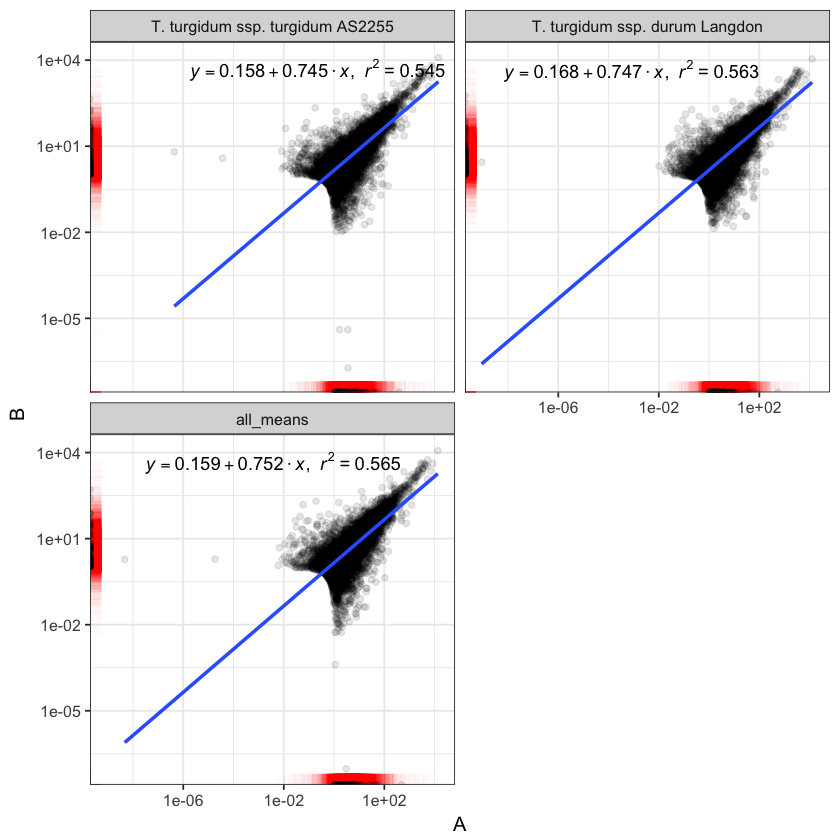

In [10]:
scatter_A_B<-ggplot(filter_hom_values, aes(x=A, y=B))+
  geom_rug(alpha = 0.01, colour= "red") + 
  geom_point(alpha = 0.1)+ facet_wrap( ~ factor, ncol=2)+
  geom_smooth(method = "lm", se=FALSE,) +
  stat_smooth_func(geom="text",method="lm",hjust=0,parse=TRUE) +
  scale_x_log10() +
  scale_y_log10() + theme_bw()
scatter_A_B

We can repeat this with the ```log2``` values

Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”

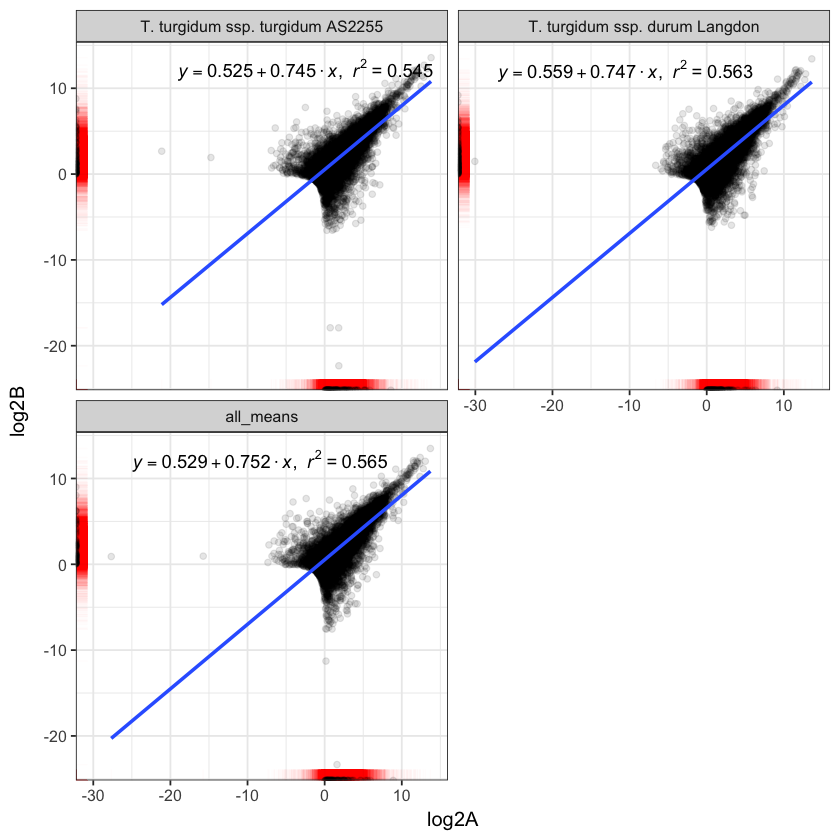

In [11]:
scatter_log_A_B<-ggplot(filter_hom_values, aes(x=log2A, y=log2B))+
  geom_rug(alpha = 0.01, colour= "red") + 
  geom_point(alpha = 0.1)+ facet_wrap( ~ factor, ncol=2)+
  geom_smooth(method = "lm", se=FALSE,) +
  stat_smooth_func(geom="text",method="lm",hjust=0,parse=TRUE) +
  theme_bw()
scatter_log_A_B

Now we can calculate the log values $$log_{n}(A)-log_{n}(B)$$ and  $$log_{2}(A)-log_{2}(B)$$.  

In [12]:
filter_hom_values$logn_ratio <- log(filter_hom_values$A) - log(filter_hom_values$B)
filter_hom_values$log2_ratio <- log2(filter_hom_values$A) - log2(filter_hom_values$B)
head(filter_hom_values)

factor    group_id A         B           A_B       log2A      log2B    
34086 all_means 412      0.7316375  1.92174250  2.653380 -0.4507991  0.942415
34094 all_means 451      1.4492995  0.38948200  1.838782  0.5353558 -1.360371
34099 all_means 474      1.1731590  0.04748205  1.220641  0.2303986 -4.396474
34100 all_means 482      0.3993320 15.39925000 15.798582 -1.3243394  3.944788
34105 all_means 575      2.2642300  0.27099725  2.535227  1.1790205 -1.883650
34106 all_means 590      5.3063875 14.96292500 20.269312  2.4077300  3.903320
      logn_ratio log2_ratio
34086 -0.9657024 -1.393214 
34094  1.3140180  1.895727 
34099  3.2071036  4.626873 
34100 -3.6522809 -5.269128 
34105  2.1228814  3.062670 
34106 -1.0366642 -1.495590

Finally, we can plot the histograms of log2 ratio. I tried first to use the density plot, but it is hard to see that the plot is slightly shifted to the rigth, which implies a small dominance of the A genome. This is consistent with the scatterplots. 

Warning message:
“Removed 748 rows containing non-finite values (stat_bin).”

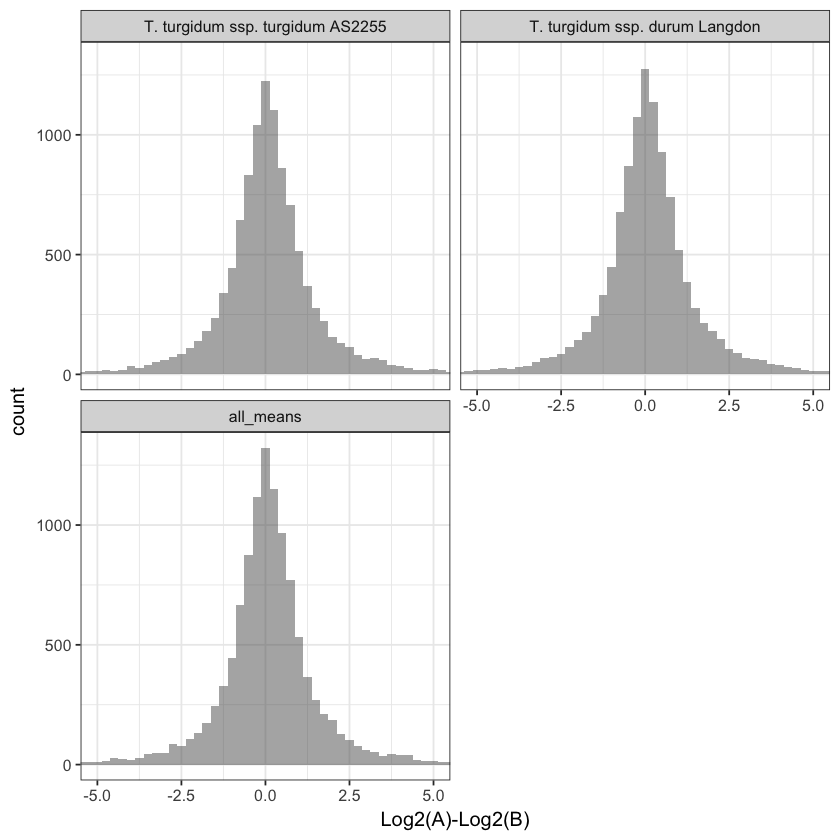

In [13]:
log2_histogram <- ggplot(filter_hom_values, aes(log2_ratio)) + 
    geom_histogram(alpha=.5, binwidth=0.25) + theme_bw() + 
    coord_cartesian(xlim = c(-5,5)) +
    facet_wrap( ~ factor, ncol=2) + 
    xlab("Log2(A)-Log2(B)")
log2_histogram

In [14]:
ggsave(plot=log2_histogram, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_log2_histogram.pdf")
ggsave(plot=scatter_A_B, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_scatter_A_B.pdf")
ggsave(plot=scatter_log_A_B,
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_scatter_log_A_B.pdf")
write.csv(filter_hom_values, 
          file="./Figures/Synthetic_dominance/Hao_2017_AB_hom_tpm.csv", row.names=F)

Saving 7 x 7 in image
Warning message:
“Removed 748 rows containing non-finite values (stat_bin).”Saving 7 x 7 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Saving 7 x 7 in image
Warning message:
“Removed 748 rows containing non-fi

In [15]:
ggsave(plot=log2_histogram, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_log2_histogram.png")
ggsave(plot=scatter_log_A_B,
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_scatter_log_A_B.png")
ggsave(plot=scatter_A_B, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_AB_scatter_A_B.png")

Saving 7 x 7 in image
Warning message:
“Removed 748 rows containing non-finite values (stat_bin).”Saving 7 x 7 in image
Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 748 rows containing non-finite values (stat_smooth).”Saving 7 x 7 in image
Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 748 rows containing non-fi

In [16]:
getSamplesForFactor<- function(metadata, type="High.level.tissue",factor="roots"){
    ret<-""
    if(type != "all"){
        ret<-as.character(metadata[metadata[,type] == factor,]$Sample.IDs)
    }else{
        ret<-as.character(unique(metadata$Sample.IDs))
    }
    ret
}

getMeansPerFactor<- function(values, metadata,  type="High.level.tissue",factor="roots"){
    samples <- getSamplesForFactor(metadata, type, factor)
    vals <- values[,samples]
    mean<-0
    if(length(samples) == 1){
        print("This factor only has one sample!")
        print(factor)
        mean<-vals
    }else{
        mean<-rowMeans(vals)
    }
    
    
    mean<-sort(mean,decreasing=T)
    cumulative <- cumsum(mean)
    
    cumulative<-data.frame(cumulative)
    mean<-data.frame(mean)
    
    mean$gene <- rownames(mean)
    cumulative$gene <- rownames(cumulative)
    mean$total_samples <- length(samples)
    
    n <-merge(mean,cumulative, by='gene', all=T)
    n <- n[order(n$cumulative,decreasing = F),]
    n$seq <- seq(from = 1, to = nrow(n))
    n$factor = factor
    n
}


getMeansForAllFactors<-function(values, metadata,  type="High.level.tissue"){
    factors<-unique(metadata[,type])
    f<-factors[1]
    meansDFs <- getMeansPerFactor(tpms,metadata,type=type, factor=f)
    for (i in 2:length(factors)){
        f<-factors[i]
        localDF<-getMeansPerFactor(tpms,metadata,type=type, factor=f)
        meansDFs <- rbind(meansDFs,localDF)
    }
    meansDFs
}

isExpressedPerFactor <- function(values, metadata,  type="High.level.tissue",factor="roots", minTPM=0.5){
    samples <- getSamplesForFactor(metadata, type, factor)
    vals <- values[,samples]
    means <- rowMeans(vals)
    expr <- means > minTPM
    m2 <- data.frame( expressed = expr)
    m2$factor<-factor
    m2$transcript<-rownames(m2)
    m2$total_samples <- length(samples)
    m2
}

getExclusiveExpression<-function(values, metadata, minTPM=0.5, type="High.level.tissue"){
    means <- getMeansForAllFactors(values, metadata,type=type)
    means$expressed<-means$mean > minTPM
    exclusiveExpresison<-sqldf("SELECT gene, factor, mean, total_samples 
        FROM means 
        WHERE expressed 
        GROUP BY gene HAVING count(factor) = 1 ")
   list(means, exclusiveExpresison )
}



reshape_triad_groups<-function(triads){
    values<-data.frame(gene=triads$A, chr_group="A", group_id=triads$group_id)
    values<-rbind(values,data.frame(gene=triads$B, chr_group="B", group_id=triads$group_id))
    values<-rbind(values,data.frame(gene=triads$D, chr_group="D", group_id=triads$group_id))
    values
}



get_triad_matrix<-function(normalised_triad, factor="all"){
    tmp<-normalised_triad[factor==normalised_triad$factor,]
    tmp<-acast(tmp, group_id~chr_group, value.var="normalised_triad") 
    tmp<-tmp[complete.cases(tmp),]
    tmp
}

plot_normalized_triads<-function(triads){
    
    p <- ggplot(triads, aes(chr_group, normalised_triad))
    p <- p + geom_boxplot(outlier.alpha = 0.05) 
    p <- p + ylab("Contribution") + xlab("Chromosome group")
    p
}

get_centroids<-function(clust_df){
    
    clusters<-sort(unique(clust_df$clust))
    n_clust<-length(clusters)
    dat <- data.frame(
        A=numeric(n_clust),B=numeric(n_clust), D=numeric(n_clust), size=numeric(n_clust), 
        clust=numeric(n_clust), description=character(n_clust),stringsAsFactors=FALSE  )
    
    for(c in clusters){
        tmp_df_clust<-clust_df[clust_df$clust==c,]
             
        dat[c,1] <- mean(tmp_df_clust$A)
        dat[c,2] <- mean(tmp_df_clust$B)
        dat[c,3] <- mean(tmp_df_clust$D)
        dat[c,4] <- nrow(tmp_df_clust)
        dat[c,5] <- c
        dat[c,6] <- paste0("other.",c)
    }
    rownames(dat)<-clusters
    dat
}

plot_clust_dist<-function(clust_df, title="All"){
    tmp_df<-clust_df[,c("A","B","D","group_id","clust","description")]
    tmp_df<-melt(tmp_df,id=c("group_id","clust","description"))
    colnames(tmp_df)<-c("group_id","clust","description","chr_group","normalised_triad")
    
    clusters<-sort(unique(tmp_df$description))
    tern <- ggtern(clust_df,aes(A,B,D,color=description, alpha=0.01)) + 
       geom_point() + theme_legend_position(x = "topleft") + scale_alpha(guide = 'none')
    gs<-list(tern)
    dat <- data.frame(
        A=numeric(0),B=numeric(0), D=numeric(0), size=numeric(0),stringsAsFactors=FALSE ) 
    
    
    rownames(dat)<-rownames(clusters)
    for(c in clusters){
        tmp_df_clust<-tmp_df[tmp_df$description==c,]
        p<-plot_normalized_triads(tmp_df_clust)
        p<- p + ylim(0,1)
        p<- p + ylab("") + xlab("")
        p<- p + ggtitle(c)
        dat[c,1] <- round(100*mean(tmp_df_clust[tmp_df_clust$chr_group=="A","normalised_triad"]),digits=2)
        dat[c,2] <- round(100*mean(tmp_df_clust[tmp_df_clust$chr_group=="B","normalised_triad"]),digits=2)
        dat[c,3] <- round(100*mean(tmp_df_clust[tmp_df_clust$chr_group=="D","normalised_triad"]),digits=2)
        dat[c,4] <- nrow(tmp_df_clust)
        gs[[length(gs)+1]] <- p
    }
    
    total_size<-sum(dat$size)
    dat$percentage<-round(100*dat$size/total_size,digits=2)
    
    gs[[length(gs)+1]]<-tableGrob(dat)
    lay <- rbind(c( 1, 1, 1, 2, 4, 7),
                 c( 1, 1, 1, 3, 5, 8),
                 c( 9, 9, 9, 6,NA,NA)
                 )

    g2 <- arrangeGrob(grobs = gs, layout_matrix = lay, top = title)
    g2
}


get_means_df<-function(metadata, tpms, type="High.level.tissue", min_mean_tpm=0.5){
    samples<-getSamplesForFactor(metadata, type="all",factor="all")
    values<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
    if(length(samples) > 1){
        print("All samples:")
        #print(samples)
        #print(colnames(tpms))
        values$value<-rowMeans(tpms[,samples])
    }else{
        values$value<-tpms[,samples]
    }
     
    values$factor<-"all"
    values$gene<-rownames(tpms)
    values$samples<-length(samples)
    
    print(unique(metadata[,type]))
    
    for(f in as.character(unique(metadata[,type]))){
        print(f)
        samples<-getSamplesForFactor(metadata, type=type,factor=f)
        
        tmp<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
        
        if(length(samples) > 1){
            tmp$value<-rowMeans(tpms[,samples])
        }else{
            tmp$value<-tpms[,samples]
        }
        
        tmp$factor<-f
        tmp$gene<-rownames(tpms)
        tmp$samples<-length(samples)
        print(colnames(values))
        print(colnames(tmp))
        values<-rbind(values,tmp)
    }
    
    casted<-dcast(values, gene~factor, value.var="value")
    casted$all<-NULL
   
    rownames(casted)<-casted$gene
    casted$gene<-NULL
    casted<-as.matrix(casted)
    print(head(casted))
    tmp<-data.frame(value=numeric(nrow(casted)),stringsAsFactors=FALSE)
    
    tmp$value<-rowMeans(casted)
    tmp$factor<-"all_means"
    tmp$gene<-rownames(casted)
    tmp$samples<-ncol(casted)
    print("...")
    print(colnames(values))
    print(colnames(tmp))
    values<-rbind(values,tmp)
    
    print(head(casted))
    print(head(min_mean_tpm))
    casted<-ifelse(casted < min_mean_tpm, NA, casted)
    print(head(casted))
    
    tmp<-data.frame(value=numeric(nrow(casted)),stringsAsFactors=FALSE)
    tmp$value<-rowMeans(casted, na.rm = TRUE)
   
    tmp$factor<-"all_mean_filter"
    tmp$gene<-rownames(casted)
    tmp$samples<-rowSums(!is.na(casted))
    print("...")
    print(colnames(values))
    print(colnames(tmp))
    
    values<-rbind(values,tmp)
    values
}

get_means_df<-function(metadata, tpms, triads, type="High.level.tissue"){
    samples<-getSamplesForFactor(metadata, type="all",factor="all")
    values<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
    if(length(samples) > 1){
        values$value<-rowMeans(tpms[,samples])
    }else{
        values$value<-tpms[,samples]
    }
     
    values$factor<-"all"
    values$gene<-rownames(tpms)
    values$samples<-length(samples)
    
    #print(unique(metadata[,type]))
    
    for(f in unique(metadata[,type])){
        #print(f)
        samples<-getSamplesForFactor(metadata, type=type,factor=f)
        
        tmp<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
        
        if(length(samples) > 1){
            tmp$value<-rowMeans(tpms[,samples])
        }else{
            tmp$value<-tpms[,samples]
        }
        
        tmp$factor<-f
        tmp$gene<-rownames(tpms)
        tmp$samples<-length(samples)
        values<-rbind(values,tmp)
    }
    
    casted<-dcast(values, gene~factor, value.var="value")
    casted$all<-NULL
   
    rownames(casted)<-casted$gene
    casted$gene<-NULL
    casted<-as.matrix(casted)
 
    tmp<-data.frame(value=numeric(nrow(casted)),stringsAsFactors=FALSE)
    tmp$value<-rowMeans(casted)
    tmp$factor<-"all_means"
    tmp$gene<-rownames(casted)
    tmp$samples<-ncol(casted)
    values<-rbind(values,tmp)
    
    triads_flat<-reshape_triad_groups(triads)
    #print(nrow(values))
    vals<-sqldf("SELECT `values`.*, chr_group, group_id FROM `values` 
LEFT JOIN triads_flat on `values`.gene = triads_flat.gene")
    vals
}


get_triad_details<-function(normalised_triad, factor="all",min_triad_sum=1){
    print("In get_triad_details")
    tmp<-normalised_triad[factor==normalised_triad$factor,]
    #print(head(tmp))
    tmp<-tmp[tmp$triad_sum>min_triad_sum,]

    norm_triad_mat<-get_triad_matrix(tmp, factor=factor)
    #print("Out of norm_triad_mat")
    #print(head(norm_triad_mat))
    centroid<-t(as.matrix(colMeans(norm_triad_mat,)))
    
    dists<-rdist(norm_triad_mat,centroid)
    rownames(dists)<-rownames(norm_triad_mat)
    colnames(dists)<-c("Distance")
    #print("Got dists")
    #print(head(dists))
    ranked_dists<-as.matrix(rank(dists)/length(dists))
    rownames(ranked_dists)<-rownames(dists)
    colnames(ranked_dists)<-c("P rank")
    #print("Ranked")
    #print(head(ranked_dists))
    rank_df<-data.frame(dists,ranked_dists)  
    rank_df$group_id<-rownames(rank_df)
    ranked_triads<-sqldf("SELECT tmp.*, Distance, `P.rank` FROM tmp NATURAL JOIN rank_df ")
    #print("Ranked_triads")
    #print(head(ranked_triads))
    t_centroid <- tableGrob(round(centroid*100,digits=2))
    p_dist<-ggplot(data=rank_df, aes(Distance)) + geom_histogram(bins=100,aes(y =..density..)) +geom_density(col=2) 
    p_rank<-ggplot(rank_df,aes(Distance,P.rank))+  geom_bin2d(bins = 75)+theme(legend.position="bottom")
    p_genome_dist<-plot_normalized_triads(tmp)
    
    s<-ifelse(nrow(rank_df)>1500,sample(1:nrow(rank_df), 1500,  replace=FALSE), 1:nrow(rank_df))
    
    rank_s <- rank_df[s,]
    title<-paste0("Genome contribution in triads: ", factor)
    p<-arrangeGrob(p_genome_dist, p_dist, t_centroid, p_rank
             , ncol=2, top = title)
    
    list(distances=rank_df,triad=tmp ,centroid=centroid, p_dist=p_dist, dist_sample=rank_s, 
         p_rank=p_rank, p_genome_dist=p_genome_dist, plot=p, ranked_triads=ranked_triads, matrix=norm_triad_mat) 
}


get_clusters_by_distance_and_plots<-function(normalized_triads, 
                                             factor="all", 
                                             output_prefix="",
                                             min_triad_sum=1,
                                             title="Triads"){
    f<-factor
    triad_test<-get_triad_details(normalized_triads,factor=factor,min_triad_sum=min_triad_sum)
    triad<-triad_test$ranked_triads
    #print("IN: get_clusters_by_distance_and_plots")
    #print(head(triad_test))
    
    test_mat<-triad_test$matrix
    mat_df<-data.frame(test_mat)
    mat_df$group_id<-rownames(test_mat)

    title<-paste0(title, ": " , f)
    
    centers<-t(matrix(c(0.33,0.33,0.33,1,0,0,0,1,0,0,0,1,0,0.5,0.5,0.5,0,0.5,0.5,0.5,0), nrow=3))
    colnames(centers)<-c("A","B","D")
    rownames(centers)<-c("Central","A.dominant","B.dominant","D.dominant","A.suppressed","B.suppressed","D.suppressed")
    
    expectation_distance<-rdist(test_mat,centers)
    colnames(expectation_distance)<-c("Central",
                                      "A.dominant",  "B.dominant",  "D.dominant",
                                      "A.suppressed","B.suppressed","D.suppressed")
    rownames(expectation_distance)<-rownames(test_mat)
    triad_test$expectation_distance<-expectation_distance
    mins<-apply( expectation_distance, 1, which.min)
    clust_desc<-colnames(expectation_distance)
    name_mins<-clust_desc[mins]
    
    
    general_desc<-c("Central","Dominant",  "Dominant",  "Dominant",
                    "Suppressed","Suppressed","Suppressed")
    
    general_name_mins<-general_desc[mins]
    
    mat_df$clust<-mins
    mat_df$description<-name_mins
    mat_df$general_description<-general_name_mins
    
    
    mat_df<-cbind(mat_df,expectation_distance)
    triad_test$triad<-mat_df
    centroids<-get_centroids(mat_df)
    
    centroids$description<-c("Central","A.dominant","B.dominant","D.dominant",
                             "A.suppressed","B.suppressed","D.suppressed" 
                             )
    
    total_genes<-sum(centroids$size)
    centroids[8,"A"]<-triad_test$centroid[,"A"]
    centroids[8,"B"]<-triad_test$centroid[,"B"]
    centroids[8,"D"]<-triad_test$centroid[,"D"]
    centroids[8,"description"] <- "Global"
    centroids[8,"size"]<-total_genes
    centroids[8,"clust"]<-8
    centroids$factor<-factor
    centroids$percentage<-centroids$size/total_genes
    
    p<-plot_clust_dist(mat_df, title=title)
    
    table_save<-sqldf("SELECT * FROM mat_df
    NATURAL LEFT JOIN triad   
    ORDER BY triad.group_id, triad.chr_group")
    table_save<-table_save[ , !(names(table_save) %in% c("A","B","D"))]
    table_save$min_triad_sum<-min_triad_sum
    triad_test$triad<-table_save
    triad_test$centroids<-centroids
    triad_test$plot_cluster<-p
    centroids$samples<-mean(triad_test$triad$samples)
    centroids$min_triad_sum<-min_triad_sum
    if(length(output_prefix) > 0){
        f2<-gsub("\n","-",f)
        f2<-gsub("/","_",f)
        p_filename<-paste0(output_prefix,"_",f2,"_triad_dist.pdf")
        ggsave(p_filename,plot=triad_test$plot,  width = 30, height = 25, units = c("cm"))
                            
        p_filename<-paste0(output_prefix,"_",f2,"_triad_cluster.pdf")
        ggsave(p_filename,plot=p,  width = 30, height = 25, units = c("cm"))
                            
        t_filename<-paste0(output_prefix,"_",f2,"_triad_cluster.txt")
        write.table(table_save, file=t_filename,
            sep="\t",quote=TRUE,row.names=FALSE, na="" )
        
        t_filename<-paste0(output_prefix,"_",f2,"_triad_centroids.txt")
        write.table(centroids, file=t_filename,
            sep="\t",quote=TRUE,row.names=FALSE, na="")
    }
    triad_test
}


ks.central<-function(meanTPMS, factor="all"){
    m<-meanTPMS[meanTPMS$factor==factor,c("description","chr_group","value")]
    
    test_df<-NULL
    for(gr in c("A","B","D")){
        central<-m[m$description=="Central" & m$chr_group==gr, "value"]
        for(d in unique(meanTPMS$description)){
            compare<-m[m$description==d & m$chr_group==gr, "value"]
            for(alt in c("less","greater")){
                test<-ks.test(central, compare, alternative=alt)
                test$chr_grp<-gr
                test$compare<-d
                test$alternative<-alt
                tmp<-data.frame(t(unlist(test)),stringsAsFactors = FALSE)
                if(is.null(test_df)){
                    test_df<-tmp
                }else{
                    colnames(tmp)<-colnames(test_df)
                    test_df<-rbind(test_df,tmp)
                }
            }
            
        }
    }
    #print(test_df$p.value)
    test_df$fdr_by<-p.adjust(as.numeric(test_df$p.value),method="BY")
    test_df$bonferroni<-p.adjust(as.numeric(test_df$p.value),method="bonferroni")
    test_df$factor<-factor
    test_df
}

plotMeansTPM<-function(meansTPM, title="Test", filename="test"){
    m1<-meansTPM[meansTPM$factor=="all_mean_filter",]
    m2<-meansTPM[meansTPM$factor!="all",]
    m2<-m2[m2$factor!="all_means",]
    m2<-m2[m2$factor!="all_mean_filter",]
    
    p <- ggplot(m1, aes(description, value, fill=chr_group))
    p <- p + geom_boxplot(outlier.alpha = 0.05) 
    p <- p + ylim(c(0, 50))
    p <- p + theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position="bottom")
    p1 <- p + ylab("TPM") + xlab("Category") 

    
    p <- ggplot(m2, aes(description, value))
    p <- p + geom_boxplot(outlier.alpha = 0.05) 
    p <- p + ylim(c(0, 50)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    p <- p + facet_wrap(~ factor,  drop = TRUE)
    
    p2 <- p + ylab("TPM") + xlab("Category") 
    
    p <- ggplot(m1, aes(description, value))
    p <- p + geom_boxplot(outlier.alpha = 0.05) 
    p <- p + ylim(c(0, 50)) 
    p  <-p + theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position="bottom")
    p3 <- p + ylab("TPM") + xlab("") 

    
    p <- ggplot(m1, aes(general_description, value, fill=chr_group))
    p <- p + geom_boxplot(outlier.alpha = 0.05) 
    p <- p + ylim(c(0, 50))
    p <- p + theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position="bottom")
    p4 <- p + ylab("TPM") + xlab("Category") 
    
    lay <- rbind(c( 3,2,2,4),
                 c( 1,2,2,NA))
    
    g2 <- arrangeGrob(p1,p2, p3,p4,layout_matrix = lay, top = title)
    
    
    p_filename<-paste0(filename,"_TPM_by_triad_disribution.pdf")
    ggsave(p_filename,plot=g2,  width = 30, height = 25, units = c("cm"))
}


get_normalized_triad_from_clusters<-function(meansTPM, triads){
    
    m2<-meansTPM[meansTPM$factor!="all",]
    m2<-m2[m2$factor!="all_means",]
    tpms<-dcast(m2, gene~factor, value.var="value",drop=FALSE, fill=NA)
    rownames(tpms)<-tpms$gene
    tpms$gene<-NULL
    
    values<-data.frame(value=numeric(nrow(tpms)),stringsAsFactors=FALSE)
   
    values$value<-rowMeans(tpms, na.rm = TRUE)
   
    values$factor<-"all_mean_filter"
    values$gene<-rownames(tpms)
    values$samples<-rowSums(!is.na(tpms))
    
    triads_flat<-reshape_triad_groups(triads)
    
    means_group<-sqldf("SELECT `values`.*, chr_group, group_id FROM `values` 
LEFT JOIN triads_flat on `values`.gene = triads_flat.gene")
    
    sums_per_group<-sqldf("SELECT group_id , factor, sum(value) as triad_sum 
FROM means_group GROUP BY group_id , factor")
    
    normalized_triads<-sqldf("SELECT means_group.*, triad_sum, value/triad_sum as normalised_triad 
FROM means_group LEFT JOIN sums_per_group 
ON  sums_per_group.group_id = means_group.group_id 
AND sums_per_group.factor = means_group.factor ")
    
    normalized_triads
}



get_triads_and_plots<-function(metadata,tpms, homologies, genes_to_use, 
                               type="High.level.tissue", 
                               dataset="All",
                               folder="./Figures/GenomeDominance/latest/non_syntenic", 
                               min_triad_sums=c(10), 
                               min_mean_triad_sums=c(0.5) ){
    triadas_with_genes<-sqldf("SELECT * from homologies 
WHERE  
A in genes_to_use 
OR B in genes_to_use 
OR D in genes_to_use 
")

    #print(head(homologies))
    #print(nrow(triadas_with_genes))
    #print(head(tpms))
    tpms_for_triads<-tpms[c(as.character(triadas_with_genes$A), 
         as.character(triadas_with_genes$B),
         as.character(triadas_with_genes$D)),]
    print(nrow(tpms_for_triads))
    #print(head(tpms_for_triads))
    means_group<-get_means_df(metadata, tpms_for_triads,triadas_with_genes, type=type)
    #means_group<-get_means_df(metadata, tpms_for_triads,type=type, min_mean_tpm=0.5)
    
    sums_per_group<-sqldf("SELECT group_id , factor, sum(value) as triad_sum 
FROM means_group GROUP BY group_id , factor")
    
    normalized_triads<-sqldf("SELECT means_group.*, triad_sum, value/triad_sum as normalised_triad 
FROM means_group LEFT JOIN sums_per_group 
ON  sums_per_group.group_id = means_group.group_id 
AND sums_per_group.factor = means_group.factor ")
    
    
    path<-paste0(folder,"/",dataset,"/",type,"/")
    
    for(min_triad_sum in min_triad_sums){
        local_triads<-NULL
        ks_ret<-NULL
        centroids<-NULL
        triads<-NULL
        path<-paste0(folder,"/",dataset,"/",type,"/min_tpm_sum_",min_triad_sum,"/")
        path<-gsub(" ","_",path)
        dir.create(path, showWarnings = TRUE, recursive = TRUE, mode = "0777")
        path<-paste0(folder,"/",dataset,"/",type,"/min_tpm_sum_",min_triad_sum,"/min_tpm_sum_",min_triad_sum)
        #print(head(normalized_triads))
        for(f in unique(normalized_triads$factor)){
            title<-paste0(dataset," triads:" , f, ".\nMinimum triad TPM sum: ", min_triad_sum)
    #        print("In loop ")
     #       print(f)
            clusters<-get_clusters_by_distance_and_plots(normalized_triads, factor=f, title=title, 
                                                         min_triad_sum=min_triad_sum,
                           output_prefix=path)
      #      print(head(clusters))
            suppressWarnings(
                tmp<-ks.central(clusters$triad, factor=f)
            )
            
            if(is.null(centroids)){
                centroids<-clusters$centroids
                triads<-clusters$triad
               
                ks_ret<-tmp
            }else{
                centroids<-rbind(centroids,clusters$centroids)
                triads<-rbind(triads,clusters$triad) 
                 
                ks_ret<-rbind(ks_ret, tmp)
            }
   
        }
        
        normalized_triads_filter<-get_normalized_triad_from_clusters(triads,triadas_with_genes )
        title<-paste0(dataset," triads:" , f, ".\nMinimum triad TPM sum: ", min_triad_sum)
        
        
        clusters<-get_clusters_by_distance_and_plots(normalized_triads_filter, factor="all_mean_filter", 
                                                     title=title, 
                                                     min_triad_sum=min_triad_sum,
                                                     output_prefix=path)
        
        centroids<-rbind(centroids,clusters$centroids)
        triads<-rbind(triads,clusters$triad) 
        
        suppressWarnings(
            tmp<-ks.central(clusters$triad, factor="all_mean_filter")
        )
        ks_ret<-rbind(ks_ret, tmp)
        
        t_filename<-paste0(path,"min_tpm_sum",min_triad_sum)
        title<-paste0("Category distribution ", dataset, "\n", type, "\n", "Min TPM average sum: ", min_triad_sum)
        plotMeansTPM(triads, filename=t_filename, title=title)
        
        t_filename<-paste0(path, "min_tpm_sum_", min_triad_sum, "_ks.txt")
        write.table(ks_ret, file=t_filename, sep="\t",quote=TRUE,row.names=FALSE, na="")
        t_filename<-paste0(path,"summary_triad_centroids.txt")
        write.table(centroids, file=t_filename, sep="\t",quote=TRUE,row.names=FALSE, na="")
        t_filename<-paste0(path,"summary_triad_cluster.txt")
        write.table(triads, file=t_filename, sep="\t",quote=TRUE,row.names=FALSE, na="")
    }
}
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              


In [17]:
hc_genes_to_use<-c(as.character(homologies$A), 
                   as.character(homologies$B), 
                   as.character(homologies$D))
head(hc_genes_to_use)
length(hc_genes_to_use)
hc_genes_to_use<-data.frame(gene=as.character(hc_genes_to_use))
head(hc_genes_to_use)

[1] "TraesCS7A01G243100" "TraesCS7A01G360600" "TraesCS7A01G267100"
[4] "TraesCS7A01G235400" "TraesCS7A01G185200" "TraesCS7A01G155800"

[1] 51108

gene              
1 TraesCS7A01G243100
2 TraesCS7A01G360600
3 TraesCS7A01G267100
4 TraesCS7A01G235400
5 TraesCS7A01G185200
6 TraesCS7A01G155800

In [18]:
get_triads_and_plots(used_metadatas_ABD,
                     tpms_ABD,
                     homologies,
                     hc_genes_to_use,
                     type="species",
                     dataset="HC_Synthetic" , 
                     min_triad_sum=c(1),
                     folder="./Figures/Synthetic_dominance/triads")


[1] 51108


Warning message in dir.create(path, showWarnings = TRUE, recursive = TRUE, mode = "0777"):
“'./Figures/Synthetic_dominance/triads/HC_Synthetic/species/min_tpm_sum_1' already exists”

[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"


Warning message:
“Removed 1669 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 3327 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1669 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1669 rows containing non-finite values (stat_boxplot).”

In [19]:
triads_syn<-read.table("./Figures/Synthetic_dominance/triads/HC_Synthetic/species/min_tpm_sum_1/min_tpm_sum_1_all_mean_filter_triad_cluster.txt", header = T)

In [20]:
head(triads_syn)

group_id clust description  general_description Central  A.dominant
1 378      2     A.dominant   Dominant            0.816517 0.0000000 
2 378      2     A.dominant   Dominant            0.816517 0.0000000 
3 378      2     A.dominant   Dominant            0.816517 0.0000000 
4 412      6     B.suppressed Suppressed          0.253069 0.6233054 
5 412      6     B.suppressed Suppressed          0.253069 0.6233054 
6 412      6     B.suppressed Suppressed          0.253069 0.6233054 
  B.dominant D.dominant A.suppressed B.suppressed ⋯ value     factor         
1 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 5.5386000 all_mean_filter
2 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 0.0000000 all_mean_filter
3 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 0.0000000 all_mean_filter
4 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.7821715 all_mean_filter
5 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.2287612 all_mean_filter
6 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.5397115 all_mean_filter
  gene               samples chr_group triad_sum normalised_triad Distance 
1 TraesCS7A01G496300 1       A         5.538600  1.0000000        0.7944679
2 TraesCS7B01G401100 1       B         5.538600  0.0000000        0.7944679
3 TraesCS7D01G483500 1       D         5.538600  0.0000000        0.7944679
4 TraesCS5A01G531900 2       A         1.550644  0.5044171        0.2513458
5 TraesCS4B01G363600 2       B         1.550644  0.1475266        0.2513458
6 TraesCS4D01G357000 2       D         1.550644  0.3480563        0.2513458
  P.rank    min_triad_sum
1 0.9916533 1            
2 0.9916533 1            
3 0.9916533 1            
4 0.6395751 1            
5 0.6395751 1            
6 0.6395751 1

In [21]:
triads_syn<-rbind(triads_syn, 
                 triads_syn<-read.table("./Figures/Synthetic_dominance/triads/HC_Synthetic/species/min_tpm_sum_1/min_tpm_sum_1_hexaploid S1 plants of AS2255 x AS60_triad_cluster.txt", 
                                        header = T))

In [22]:
triads_syn<-rbind(triads_syn, 
                 triads_syn<-read.table("./Figures/Synthetic_dominance/triads/HC_Synthetic/species/min_tpm_sum_1/min_tpm_sum_1_hexaploid S1 plants of Langdon x AS60_triad_cluster.txt", 
                                        header = T))

In [23]:
unique(triads_syn$factor)

[1] all_mean_filter                       hexaploid S1 plants of AS2255 x AS60 
[3] hexaploid S1 plants of Langdon x AS60
3 Levels: all_mean_filter ... hexaploid S1 plants of Langdon x AS60

Warning message:
“Ignoring unknown parameters: binwidth”Warning message:
“Removed 637 rows containing non-finite values (stat_density).”

Warning message:
“Ignoring unknown parameters: binwidth”Warning message:
“Removed 554 rows containing non-finite values (stat_density).”

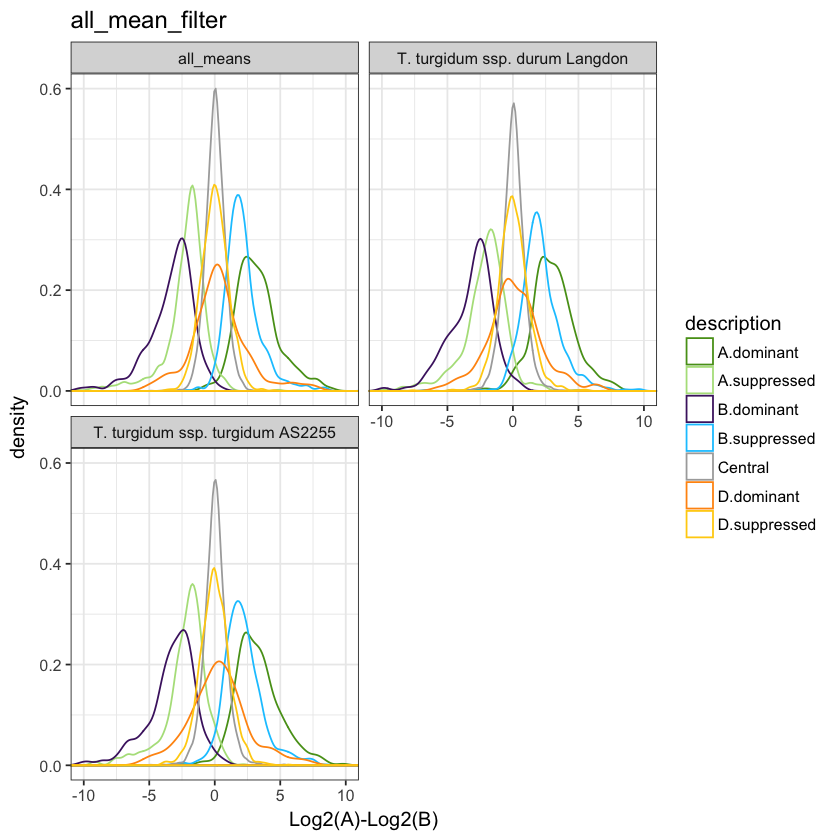

Warning message:
“Ignoring unknown parameters: binwidth”Warning message:
“Removed 595 rows containing non-finite values (stat_density).”

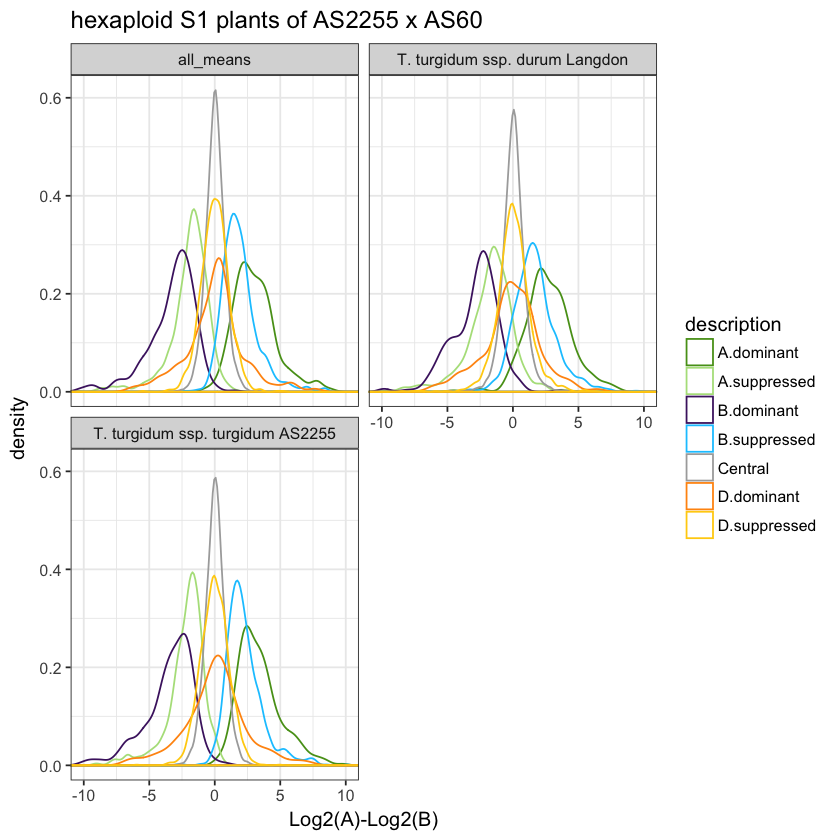

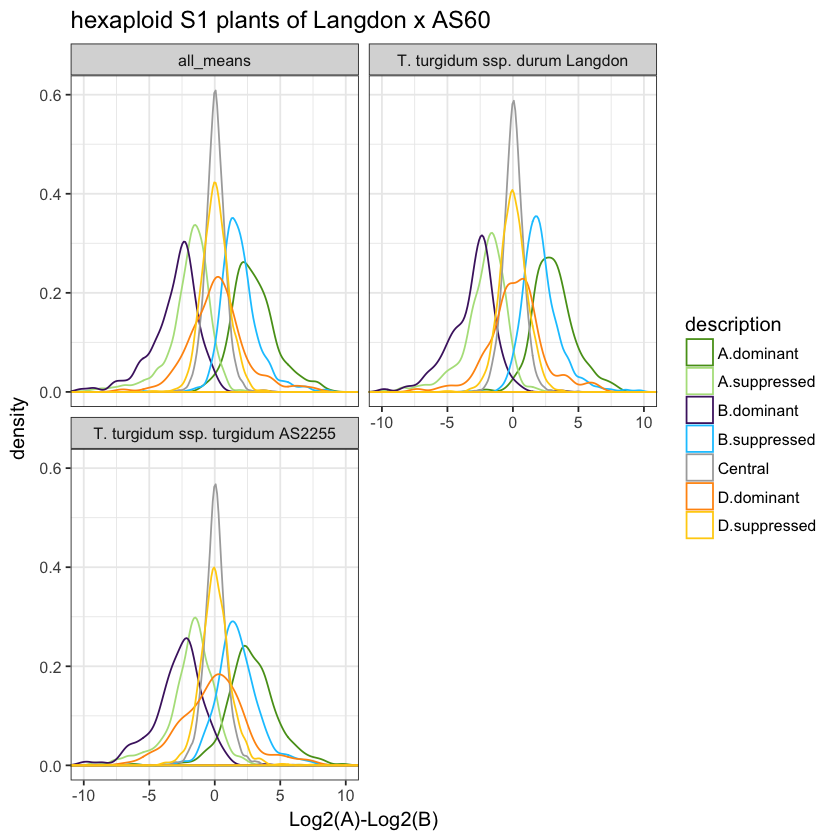

In [24]:
plot_tetraploid_from_movment<-function(triads, 
                                       tetraploid_hom_values, 
                                       factor="all_mean_filter", 
                                       group.colors=c(A.dominant = "#579D1C", 
                                                      B.dominant = "#4B1F6F", 
                                                      D.dominant ="#FF950E", 
                                                      Central="#AAAAAA", 
                                                      A.suppressed = "#b2E08a",
                                                      B.suppressed = "#0eC7ff",
                                                      D.suppressed ="#ffCF0e")){
    local_triads<-triads[triads$factor == factor, c("factor", "description","group_id")]
    local_triads<-unique(local_triads)
    hom_values<-sqldf("SELECT tetraploid_hom_values.*,
description,
local_triads.factor as hexaploid_factor  FROM
local_triads 
JOIN tetraploid_hom_values ON local_triads.group_id = tetraploid_hom_values.group_id
")      
    #hom_values$factor <- factor(hom_values$factor, 
    #                                   levels = c("HD", "12DAA", "22DAA", "all_means"))


    p <- ggplot(hom_values, aes(log2_ratio, color = description))
    p <- p + geom_density(alpha=.5, binwidth=0.25) + theme_bw()  
    p <- p + coord_cartesian(xlim = c(-10,10)) 
    p <- p + facet_wrap( ~ factor, ncol=2)  
    p <- p + xlab("Log2(A)-Log2(B)")
    p <- p + scale_color_manual(values=group.colors)
    p <- p + ggtitle(factor)
    p
}
p1<-plot_tetraploid_from_movment(triads_syn, filter_hom_values)
p1
p2<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, factor="hexaploid S1 plants of AS2255 x AS60")
p2
p3<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, factor="hexaploid S1 plants of Langdon x AS60")
p3

In [25]:
ggsave(plot=p1,
       filename = "./Figures/Synthetic_dominance/Hao_2017_density_all_means_filter_category.pdf")
ggsave(plot=p2, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_density_AS2255xAS60_category.pdf")
ggsave(plot=p3, 
       filename = "./Figures/Synthetic_dominance/Hao_2017_density_LangdonxAS60_category.pdf")

Saving 7 x 7 in image
Warning message:
“Removed 637 rows containing non-finite values (stat_density).”Saving 7 x 7 in image
Warning message:
“Removed 554 rows containing non-finite values (stat_density).”Saving 7 x 7 in image
Warning message:
“Removed 595 rows containing non-finite values (stat_density).”

Saving 7 x 7 in image


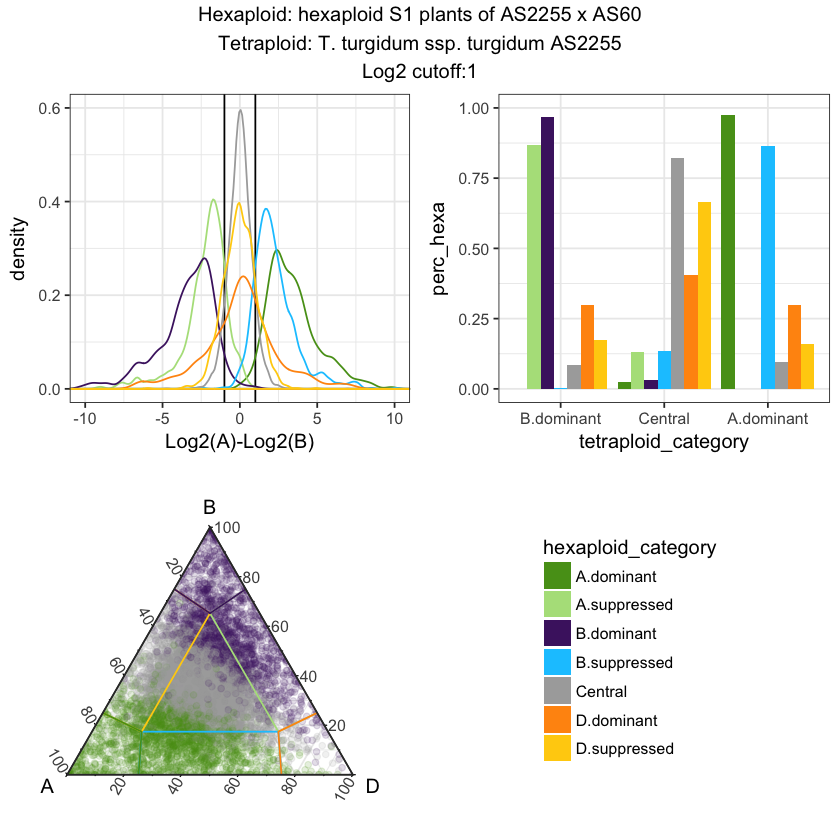

In [26]:
plot_tetraploid_from_movment<-function(triads, 
                                       tetraploid_hom_values, 
                                       factor="all_mean_filter", 
                                       folder="./Figures/Synthetic_dominance/",
                                       study="Hao_2017",
                                       log2_cutoff = 1,
                                       factor_tetraploid = "all_means",
                                       group.colors=c(A.dominant = "#579D1C", 
                                                      B.dominant = "#4B1F6F", 
                                                      D.dominant ="#FF950E", 
                                                      Central="#AAAAAA", 
                                                      A.suppressed = "#b2E08a",
                                                      B.suppressed = "#0eC7ff",
                                                      D.suppressed ="#ffCF0e")){
    options(warn=-1)
    clusters<-c("Central",
                "A.suppressed", "B.suppressed","D.suppressed",
                "A.dominant"  , "B.dominant"  ,"D.dominant")
    
    
    local_triads<-triads[triads$factor == factor, c("gene", "factor", "description","group_id","value",
                                                    "normalised_triad", "chr_group")]
    tetraploid_hom_values<-tetraploid_hom_values[tetraploid_hom_values$factor == factor_tetraploid, 
                                                 c("group_id",  "factor", "A", "B", "log2_ratio") ]
    local_triads<-unique(local_triads)
    hom_values<-sqldf("SELECT tetraploid_hom_values.*,
description as hexaploid_category,value as hexaploid_value,
normalised_triad, gene, chr_group,
local_triads.factor as hexaploid_factor  FROM
local_triads 
JOIN tetraploid_hom_values ON local_triads.group_id = tetraploid_hom_values.group_id
")      
    hom_values$tetraploid_category<- ifelse( hom_values$log2_ratio < -1 * log2_cutoff, 
                                    "B.dominant", 
                                     ifelse( hom_values$log2_ratio > log2_cutoff , "A.dominant",
                                            "Central" ))
    hom_values$tetraploid_category <- factor(hom_values$tetraploid_category, 
                                       levels = c("B.dominant", "Central", "A.dominant"))
    #hom_values$factor <- factor(hom_values$factor, 
    #                                   levels = c("HD", "12DAA", "22DAA", "all_means"))
    cuts <- data.frame(vals = c(log2_cutoff, -1 * log2_cutoff))
    
    tetraploid_categories <- data.frame(tetraploid_category=c("B.dominant", "Central", "A.dominant"))
    hexplod_categories <-   data.frame(hexaploid_category=clusters)
    
    all_categories <- sqldf("SELECT * FROM tetraploid_categories,hexplod_categories ")
    #print(all_categories)
    
    counts_hom <- sqldf("SELECT all_categories.tetraploid_category, 
all_categories.hexaploid_category, count(hom_values.tetraploid_category)  as count
FROM all_categories
LEFT JOIN hom_values 
ON hom_values.tetraploid_category =  all_categories.tetraploid_category 
AND hom_values.hexaploid_category =  all_categories.hexaploid_category 
GROUP BY all_categories.tetraploid_category, all_categories.hexaploid_category" )
    
    
    counts_hex <- sqldf("SELECT hexaploid_category, count(*)  as count_hexa
FROM hom_values
GROUP BY hexaploid_category" )
    
    counts_tetr <- sqldf("SELECT tetraploid_category, count(*)  as count_tetra
FROM hom_values
GROUP BY tetraploid_category" )
    
    counts_hom<- merge(x=counts_hom, y=counts_hex)
    counts_hom<- merge(x=counts_hom, y=counts_tetr)
    counts_hom$perc_hexa  <- counts_hom$count   / counts_hom$count_hexa
    counts_hom$perc_tetra <- counts_hom$count   / counts_hom$count_tetra
    
    counts_hom$tetraploid_category <- factor(counts_hom$tetraploid_category, 
                                       levels = c("B.dominant", "Central", "A.dominant"))
    
    title <- paste0("Hexaploid: ", factor, "\nTetraploid: ", factor_tetraploid, "\nLog2 cutoff:", log2_cutoff )
    p <- ggplot(hom_values, aes(log2_ratio, color = hexaploid_category))
    p <- p +  geom_vline(data=cuts, 
             aes(xintercept=vals)) 
    p <- p + geom_density(alpha=.5, binwidth=0.25) + theme_bw()  
    p <- p + coord_cartesian(xlim = c(-10,10), ylim = c(0,0.6))   
    p <- p + xlab("Log2(A)-Log2(B)")
    p <- p + scale_color_manual(values=group.colors)
    p <- p + theme(legend.position = "none") 
                                
    #p2  <- ggplot(df.new, aes(tetraploid_category, prop, fill=hexaploid_category )) 
    #p2  <- p2 + geom_bar()
    p2 <-  ggplot(counts_hom,aes(tetraploid_category,perc_hexa,fill=hexaploid_category)) 
    p2 <- p2+ geom_bar(stat="identity",position='dodge')  
    p2 <- p2 + coord_cartesian(ylim = c(0,1))
    p2 <- p2 + scale_fill_manual(values=group.colors)
    p2 <- p2 + theme_bw()
    legend <- get_legend(p2)
    p2 <- p2 + theme(legend.position = "none") 
    
    
    central_limit<-0.75
    suppressed_limit<-0.20
    dominant_limit<-0.25

   central <- data.frame(
      A = c(central_limit, suppressed_limit,  suppressed_limit  , central_limit),
      B = c(suppressed_limit,central_limit, suppressed_limit , suppressed_limit),
      D = c(suppressed_limit,suppressed_limit,  central_limit, suppressed_limit)
    
    )

   A.Dominant<-data.frame(
      A = c(1-dominant_limit, central_limit, 1-dominant_limit  ),
      B = c(0 ,suppressed_limit ,dominant_limit ),
      D = c(dominant_limit, suppressed_limit,0 )
    
    )
   B.Dominant<-data.frame(
      
    A = c(0 ,suppressed_limit ,dominant_limit ),
    B = c(1-dominant_limit, central_limit, 1-dominant_limit  ),  
    D = c(dominant_limit, suppressed_limit,0 )
    
    )
    D.Dominant<-data.frame(  
      A = c(dominant_limit, suppressed_limit,0 ),
      B = c(0 ,suppressed_limit ,dominant_limit ),
      D = c(1-dominant_limit, central_limit, 1-dominant_limit )
    )
    
   A.Suppressed<-data.frame(
      A = c(0, suppressed_limit, suppressed_limit, 0),
      B = c(dominant_limit ,suppressed_limit ,central_limit, 1-dominant_limit),
      D = c(1-dominant_limit, central_limit,suppressed_limit, dominant_limit )
    )
    
    B.Suppressed<-data.frame(
        A = c(dominant_limit ,suppressed_limit ,central_limit, 1-dominant_limit),  
        B = c(0, suppressed_limit, suppressed_limit, 0),
        D = c(1-dominant_limit, central_limit,suppressed_limit, dominant_limit )
    )
    
    D.Suppressed<-data.frame(
        A = c(1-dominant_limit, central_limit,suppressed_limit, dominant_limit ),
        B = c(dominant_limit ,suppressed_limit ,central_limit, 1-dominant_limit),
        D = c(0, suppressed_limit, suppressed_limit, 0)  
    
    )
    
    
    lines <-  rbind(data.frame(A.Dominant,Series='A.dominant', print="Central"),
                data.frame(B.Dominant,Series='B.dominant', print="Central"),
                data.frame(D.Dominant,Series='D.dominant', print="Central"), 
                data.frame(A.Suppressed, Series="A.suppressed", print="Central"),
                data.frame(B.Suppressed, Series="B.suppressed", print="Central"),
                data.frame(D.Suppressed, Series="D.suppressed", print="Central"),
                
                data.frame(central,Series='Central', print="Dominant"),
                data.frame(A.Suppressed, Series="A.suppressed", print="Dominant"),
                data.frame(B.Suppressed, Series="B.suppressed", print="Dominant"),
                data.frame(D.Suppressed, Series="D.suppressed", print="Dominant"),
                
                data.frame(central,Series='Central', print="Suppressed"),
                data.frame(A.Dominant,Series='A.dominant', print="Suppressed"),
                data.frame(B.Dominant,Series='B.dominant', print="Suppressed"),
                data.frame(D.Dominant,Series='D.dominant', print="Suppressed") 
               ) 
    
    
    lines$Series = factor( lines$Series,levels = clusters)
    group.alpha<-c(A.dominant = 0.2, B.dominant = 0.2, D.dominant =0.2, 
             Central=0.2, 
             A.suppressed = 0.2, B.suppressed = 0.2, D.suppressed = 0.2)
    
    clust_df <- dcast(hom_values, group_id  + tetraploid_category + factor  ~ 
                      chr_group, value.var = "normalised_triad")
    local_lines<-lines[lines$print=="Central",]
    p3 <- ggtern(clust_df,aes(A,B,D,color=tetraploid_category)) + theme_bw()  
    p3 <- p3 + geom_point(alpha=0.15)
    #p3 <- p3 + scale_alpha_manual(values=group.alpha) 
    p3 <- p3 + geom_path(data=local_lines, aes(A,B,D, color=Series))
    p3 <- p3 + scale_color_manual(values=group.colors) + theme(legend.position = "none") 
    p3
    
    prefix <- paste0(factor, "_", factor_tetraploid, "_", log2_cutoff )
    hom_values$log2_cutoff <- log2_cutoff
    hom_values$hexaploid <- factor
    hom_values$tetraploid <- factor_tetraploid
    
    write.csv(hom_values, file=paste0(folder, "/", prefix,"_hom_values.csv"))
    
    counts_hom$log2_cutoff <- log2_cutoff
    counts_hom$hexaploid <- factor
    counts_hom$tetraploid <- factor_tetraploid
    
    write.csv(counts_hom, file=paste0(folder, "/", prefix,"_counts_hom.csv"))
    lay <- rbind(c( 1, 2),
                 c( 3, 4)
                 )

    g2 <- arrangeGrob(grobs = list(p, p2, p3,legend) , layout_matrix = lay, top = title)
    
    ggsave(g2, filename = paste0(folder, "/", prefix,"_categories.pdf"))
    g2
}
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of AS2255 x AS60", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=1)
grid.draw(g)


Saving 7 x 7 in image


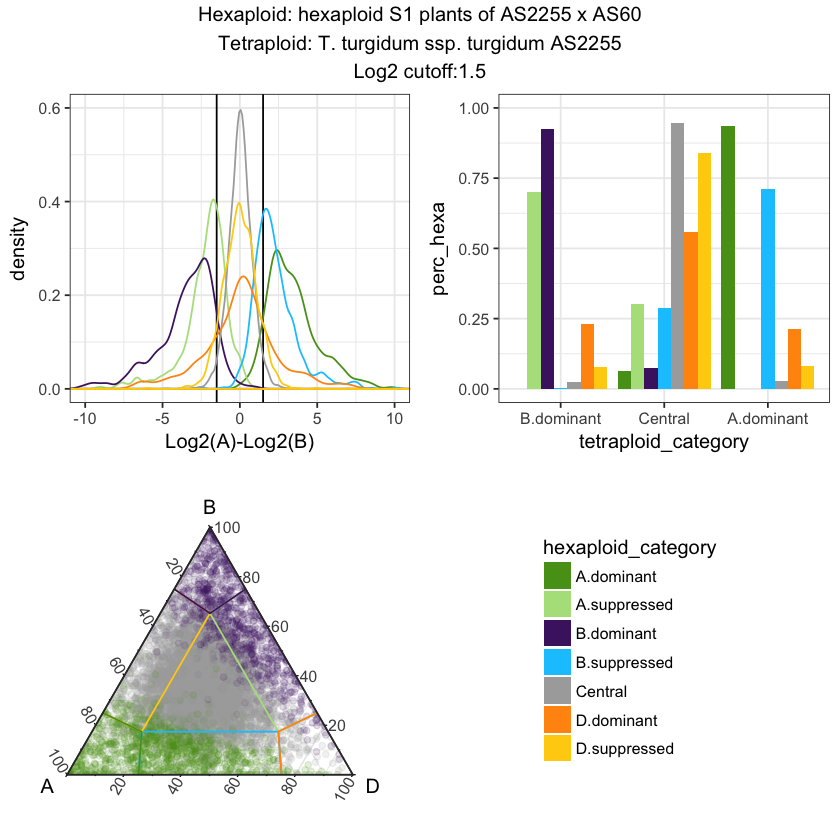

In [27]:
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of AS2255 x AS60", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=1.5)
grid.draw(g)

Saving 7 x 7 in image


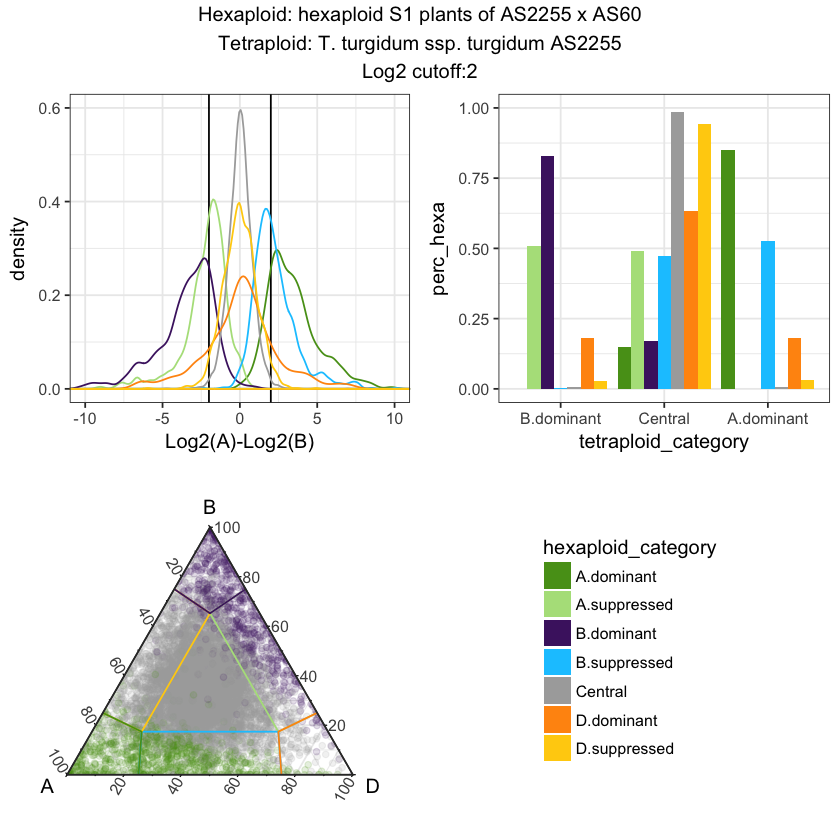

In [28]:
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of AS2255 x AS60", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=2)
grid.draw(g)

In [29]:
head(triads_syn)

group_id clust description  general_description Central  A.dominant
1 378      2     A.dominant   Dominant            0.816517 0.0000000 
2 378      2     A.dominant   Dominant            0.816517 0.0000000 
3 378      2     A.dominant   Dominant            0.816517 0.0000000 
4 412      6     B.suppressed Suppressed          0.253069 0.6233054 
5 412      6     B.suppressed Suppressed          0.253069 0.6233054 
6 412      6     B.suppressed Suppressed          0.253069 0.6233054 
  B.dominant D.dominant A.suppressed B.suppressed ⋯ value     factor         
1 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 5.5386000 all_mean_filter
2 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 0.0000000 all_mean_filter
3 1.414214   1.4142136  1.2247449    0.7071068    ⋯ 0.0000000 all_mean_filter
4 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.7821715 all_mean_filter
5 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.2287612 all_mean_filter
6 1.049900   0.8373956  0.6338462    0.2118266    ⋯ 0.5397115 all_mean_filter
  gene               samples chr_group triad_sum normalised_triad Distance 
1 TraesCS7A01G496300 1       A         5.538600  1.0000000        0.7944679
2 TraesCS7B01G401100 1       B         5.538600  0.0000000        0.7944679
3 TraesCS7D01G483500 1       D         5.538600  0.0000000        0.7944679
4 TraesCS5A01G531900 2       A         1.550644  0.5044171        0.2513458
5 TraesCS4B01G363600 2       B         1.550644  0.1475266        0.2513458
6 TraesCS4D01G357000 2       D         1.550644  0.3480563        0.2513458
  P.rank    min_triad_sum
1 0.9916533 1            
2 0.9916533 1            
3 0.9916533 1            
4 0.6395751 1            
5 0.6395751 1            
6 0.6395751 1

Now, we can produce an artificial *in silico* mix 

In [30]:
#head(used_metadatas_ABD)
#head(tpms_ABD)
head(used_metadatas_AB)
#head(tpms_AB)
head(used_metadatas_D)
#head(tpms_D)

silico_tpms_AB<-tpms_AB[,c("SRR3474199","SRR3474201")] * (2/3)
silico_tpms_D<-tpms_D * (1/3)
colnames(silico_tpms_D)<-c("SRR3474199","SRR3474201")
silico_tpms_ABD<-rbind(silico_tpms_AB,silico_tpms_D)
used_metadatas_silico_ABD<-used_metadatas_AB[used_metadatas_AB$Sample.IDs %in% c("SRR3474199","SRR3474201"),]
used_metadatas_silico_ABD$species <- "In Silico"
head(silico_tpms_ABD)
head(used_metadatas_silico_ABD)

Sample.IDs study_title
1 SRR3474199 PRJNA319131
2 SRR3474201 PRJNA319131
3 SRR3474195 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_1.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_2.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_2.fastq.gz
  species                         
1 T. turgidum ssp. turgidum AS2255
2 T. turgidum ssp. turgidum AS2255
3 T. turgidum ssp. durum Langdon

Sample.IDs study_title
1 SRR3406932 PRJNA319131
2 SRR3474194 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_2.fastq.gz
  species        
1 Ae. tauschii AS
2 Ae. tauschii AS

SRR3474199 SRR3474201
TraesCS1A01G000100LC 1.3569667  1.120060  
TraesCS1A01G000100   0.2380740  0.334078  
TraesCS1A01G000200LC 0.0000000  0.000000  
TraesCS1A01G000200   0.0616612  0.000000  
TraesCS1A01G000300LC 0.0000000  0.000000  
TraesCS1A01G000300   1.5432333  1.188247

Sample.IDs study_title
1 SRR3474199 PRJNA319131
2 SRR3474201 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_2.fastq.gz
  species  
1 In Silico
2 In Silico

In [31]:
get_triads_and_plots(used_metadatas_silico_ABD,
                     silico_tpms_ABD,
                     homologies,
                     hc_genes_to_use,
                     type="species",
                     dataset="HC_in_silico" , 
                     min_triad_sum=c(1),
                     folder="./Figures/Synthetic_dominance/triads")

[1] 51108
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"


In [32]:
triads_silico<-read.table("./Figures/Synthetic_dominance/triads/HC_in_silico/species/min_tpm_sum_1/min_tpm_sum_1_In Silico_triad_cluster.txt", header = T)

In [33]:
head(triads_silico)

group_id clust description general_description Central   A.dominant
1 412      1     Central     Central             0.1805314 0.9581665 
2 412      1     Central     Central             0.1805314 0.9581665 
3 412      1     Central     Central             0.1805314 0.9581665 
4 451      1     Central     Central             0.1539918 0.7244375 
5 451      1     Central     Central             0.1539918 0.7244375 
6 451      1     Central     Central             0.1539918 0.7244375 
  B.dominant D.dominant A.suppressed B.suppressed ⋯ value     factor   
1 0.8721546  0.6472543  0.2996596    0.4105004    ⋯ 0.8511800 In Silico
2 0.8721546  0.6472543  0.2996596    0.4105004    ⋯ 1.1504167 In Silico
3 0.8721546  0.6472543  0.2996596    0.4105004    ⋯ 1.7999383 In Silico
4 0.9679091  0.7806297  0.5226044    0.2590294    ⋯ 0.7118060 In Silico
5 0.9679091  0.7806297  0.5226044    0.2590294    ⋯ 0.3593787 In Silico
6 0.9679091  0.7806297  0.5226044    0.2590294    ⋯ 0.6394683 In Silico
  gene               samples chr_group triad_sum normalised_triad Distance 
1 TraesCS5A01G531900 2       A         3.801535  0.2239043        0.1838815
2 TraesCS4B01G363600 2       B         3.801535  0.3026190        0.1838815
3 TraesCS4D01G357000 2       D         3.801535  0.4734767        0.1838815
4 TraesCS3A01G462400 2       A         1.710653  0.4161019        0.1438233
5 TraesCS3B01G505400 2       B         1.710653  0.2100827        0.1438233
6 TraesCS3D01G456100 2       D         1.710653  0.3738153        0.1438233
  P.rank    min_triad_sum
1 0.4752899 1            
2 0.4752899 1            
3 0.4752899 1            
4 0.3508475 1            
5 0.3508475 1            
6 0.3508475 1

Saving 7 x 7 in image


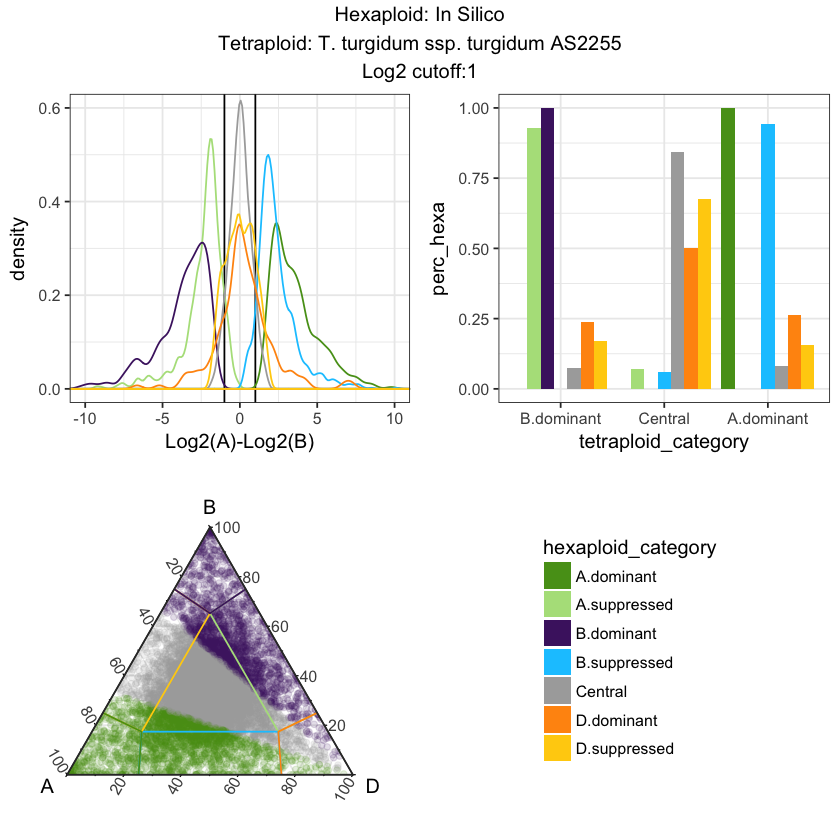

In [34]:
g<-plot_tetraploid_from_movment(triads_silico, filter_hom_values, 
                                 factor="In Silico", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=1)
grid.draw(g)

Saving 7 x 7 in image


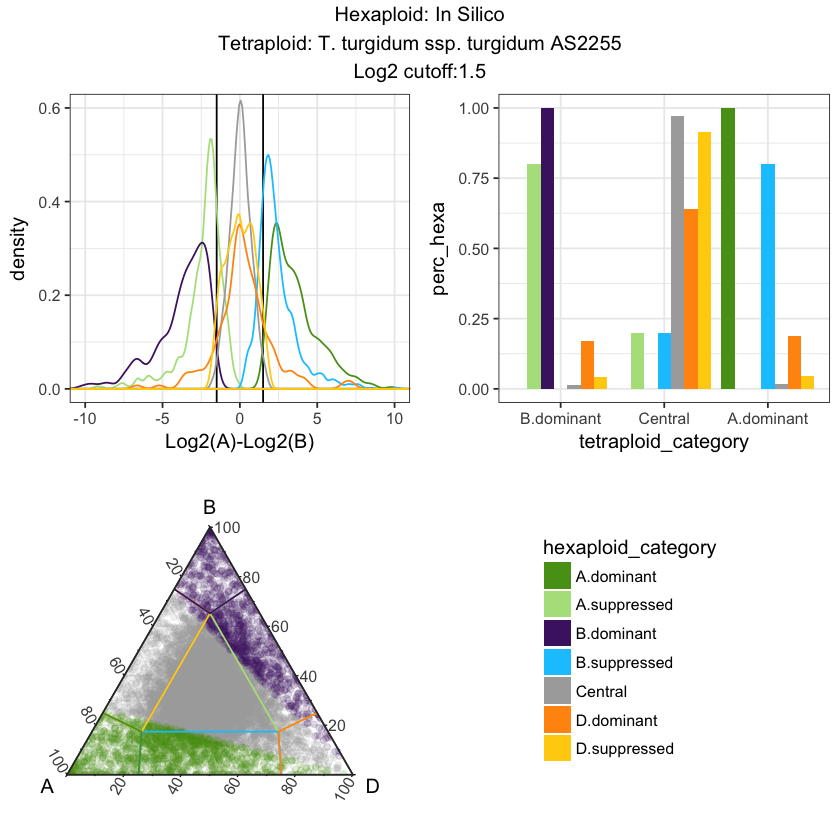

In [35]:
g<-plot_tetraploid_from_movment(triads_silico, filter_hom_values, 
                                 factor="In Silico", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=1.5)
grid.draw(g)

Saving 7 x 7 in image


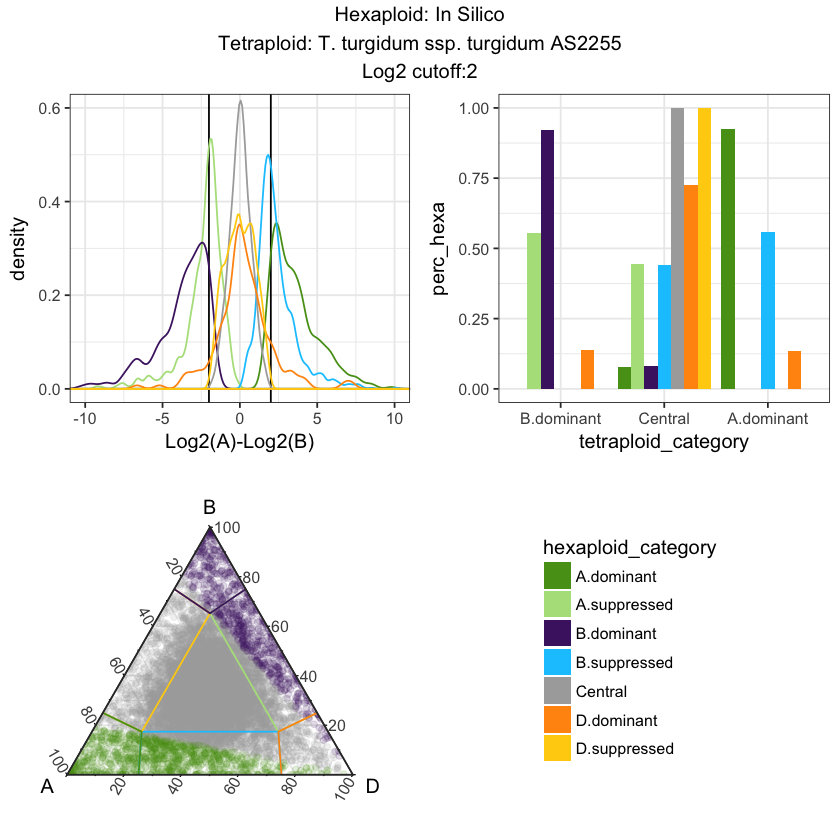

In [36]:
g<-plot_tetraploid_from_movment(triads_silico, filter_hom_values, 
                                 factor="In Silico", 
                                factor_tetraploid="T. turgidum ssp. turgidum AS2255", log2_cutoff=2)
grid.draw(g)

In [37]:
#head(used_metadatas_ABD)
#head(tpms_ABD)
head(used_metadatas_AB)
#head(tpms_AB)
head(used_metadatas_D)
#head(tpms_D)

langdon_silico_tpms_AB<-tpms_AB[,c("SRR3474195","SRR3474195")] * (2/3)
colnames(langdon_silico_tpms_AB)
colnames(langdon_silico_tpms_AB)<-c("SRR3406932","SRR3474194")
langdon_silico_tpms_D<-tpms_D * (1/3)
colnames(langdon_silico_tpms_AB)
colnames(langdon_silico_tpms_D)
langdon_silico_tpms_ABD<-rbind(langdon_silico_tpms_AB,
                               langdon_silico_tpms_D)
used_metadatas_langdon_silico_ABD<-used_metadatas_D
used_metadatas_langdon_silico_ABD$species <- "In Silico Langdon"
head(langdon_silico_tpms_ABD)
head(used_metadatas_langdon_silico_ABD)

Sample.IDs study_title
1 SRR3474199 PRJNA319131
2 SRR3474201 PRJNA319131
3 SRR3474195 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_1.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474199_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474201_2.fastq.gz
3 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474195_2.fastq.gz
  species                         
1 T. turgidum ssp. turgidum AS2255
2 T. turgidum ssp. turgidum AS2255
3 T. turgidum ssp. durum Langdon

Sample.IDs study_title
1 SRR3406932 PRJNA319131
2 SRR3474194 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_2.fastq.gz
  species        
1 Ae. tauschii AS
2 Ae. tauschii AS

[1] "SRR3474195"   "SRR3474195.1"

[1] "SRR3406932" "SRR3474194"

[1] "SRR3406932" "SRR3474194"

SRR3406932 SRR3474194
TraesCS1A01G000100LC 1.3164400  1.3164400 
TraesCS1A01G000100   0.1739527  0.1739527 
TraesCS1A01G000200LC 0.0000000  0.0000000 
TraesCS1A01G000200   0.1839173  0.1839173 
TraesCS1A01G000300LC 0.3843740  0.3843740 
TraesCS1A01G000300   1.3137667  1.3137667

Sample.IDs study_title
1 SRR3406932 PRJNA319131
2 SRR3474194 PRJNA319131
  left                                                                                     
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_1.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_1.fastq.gz
  right                                                                                    
1 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3406932_2.fastq.gz
2 /usr/users/ga002/ramirezr/Cristobal-Uauy/ramirezr/reads/PRJNA319131/SRR3474194_2.fastq.gz
  species          
1 In Silico Langdon
2 In Silico Langdon

In [38]:
get_triads_and_plots(used_metadatas_langdon_silico_ABD,
                     langdon_silico_tpms_ABD,
                     homologies,
                     hc_genes_to_use,
                     type="species",
                     dataset="HC_in_silico_langdon" , 
                     min_triad_sum=c(1),
                     folder="./Figures/Synthetic_dominance/triads")

[1] 51108
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"
[1] "In get_triad_details"


In [39]:
triads_silico_langdon<-read.table("./Figures/Synthetic_dominance/triads/HC_in_silico_langdon/species/min_tpm_sum_1/min_tpm_sum_1_In Silico Langdon_triad_cluster.txt", header = T)

In [40]:
unique(filter_hom_values$factor)
unique(triads_syn$factor)

[1] all_means                        T. turgidum ssp. durum Langdon  
[3] T. turgidum ssp. turgidum AS2255
3 Levels: T. turgidum ssp. turgidum AS2255 ... all_means

[1] all_mean_filter                       hexaploid S1 plants of AS2255 x AS60 
[3] hexaploid S1 plants of Langdon x AS60
3 Levels: all_mean_filter ... hexaploid S1 plants of Langdon x AS60

Saving 7 x 7 in image


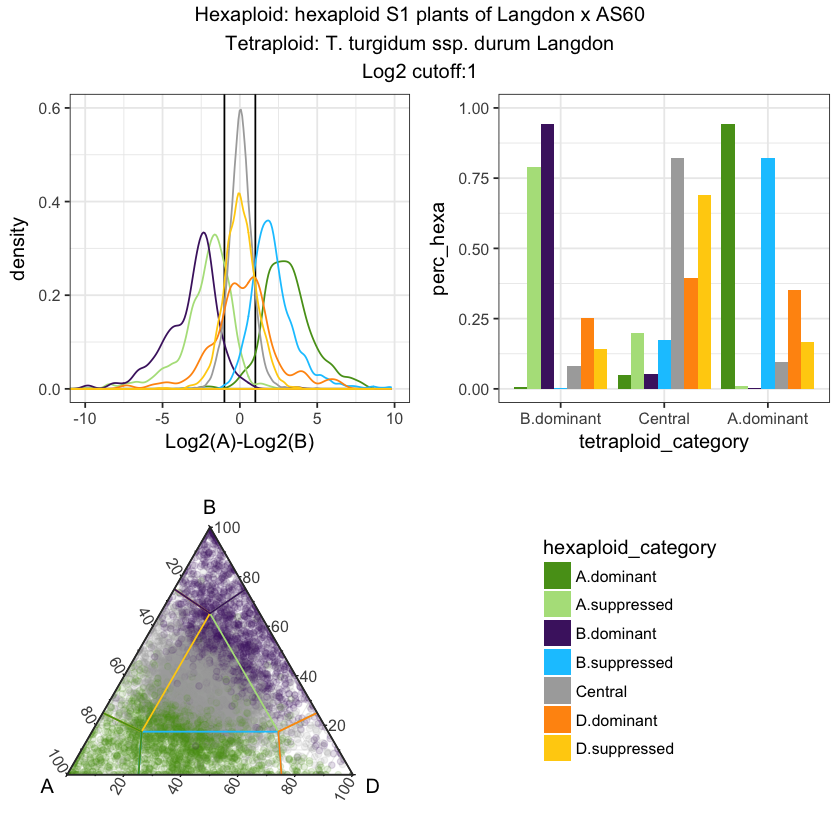

In [41]:
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of Langdon x AS60", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon",
                                log2_cutoff=1)
grid.draw(g)

Saving 7 x 7 in image
Saving 7 x 7 in image


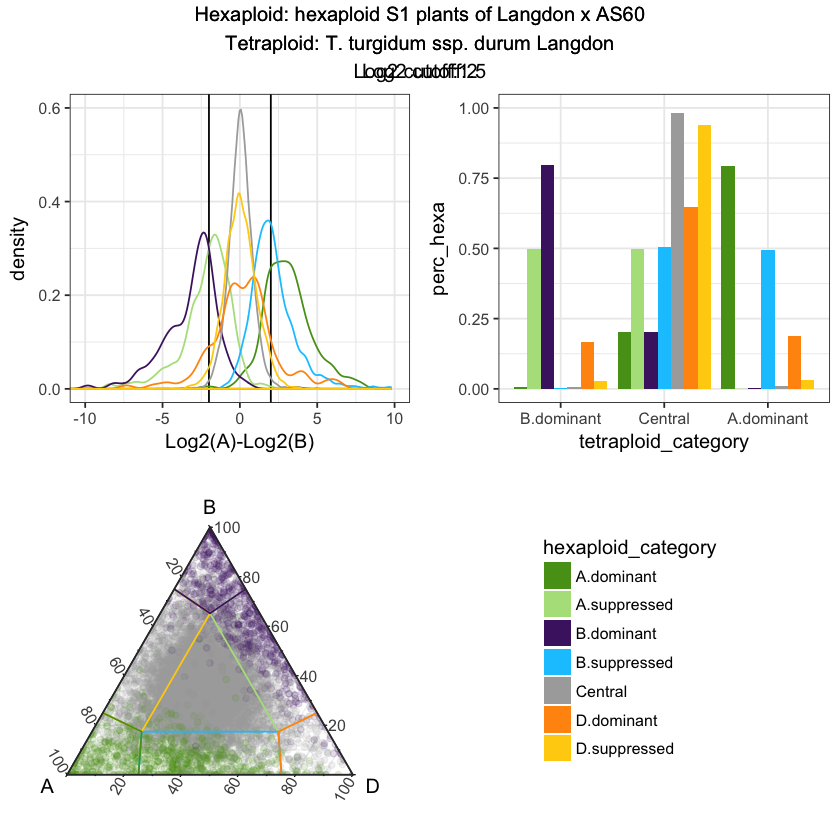

In [42]:
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of Langdon x AS60", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon",
                                log2_cutoff=1.5)
grid.draw(g)
g<-plot_tetraploid_from_movment(triads_syn, filter_hom_values, 
                                 factor="hexaploid S1 plants of Langdon x AS60", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon",
                                log2_cutoff=2)
grid.draw(g)

Saving 7 x 7 in image


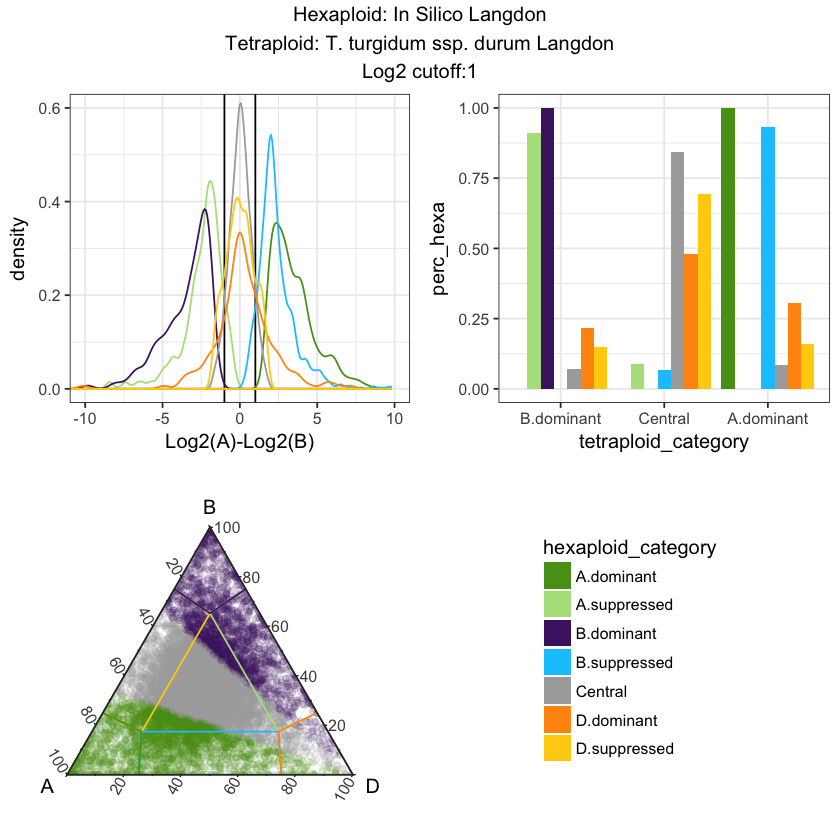

In [43]:
g<-plot_tetraploid_from_movment(triads_silico_langdon, filter_hom_values, 
                                 factor="In Silico Langdon", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon", 
                                log2_cutoff=1)
grid.draw(g)


Saving 7 x 7 in image


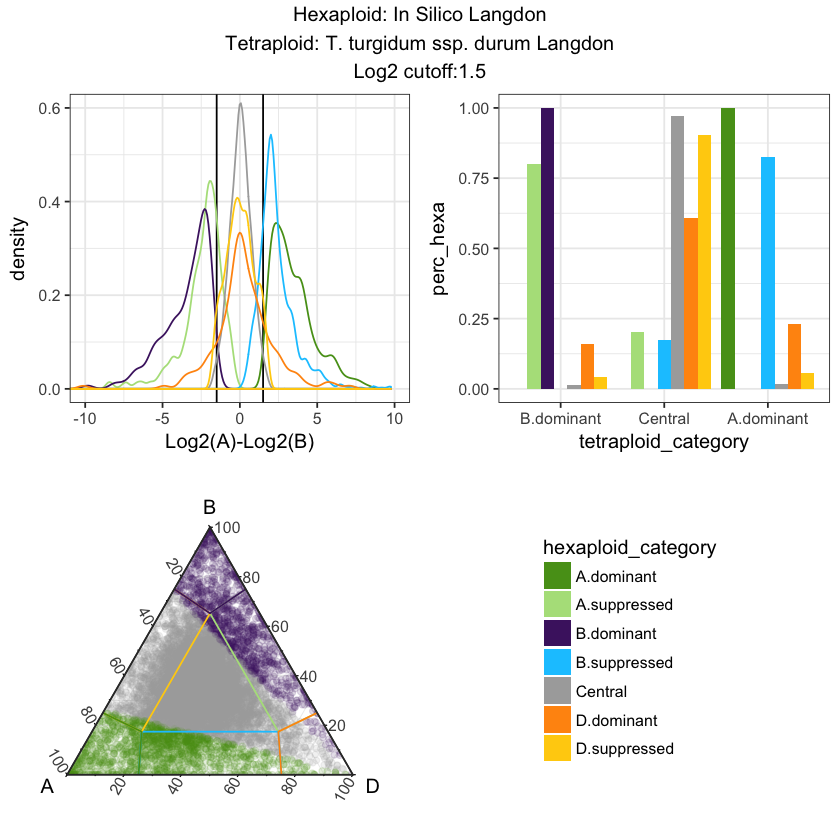

In [44]:
g<-plot_tetraploid_from_movment(triads_silico_langdon, filter_hom_values, 
                                 factor="In Silico Langdon", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon", 
                                log2_cutoff=1.5)
grid.draw(g)





Saving 7 x 7 in image


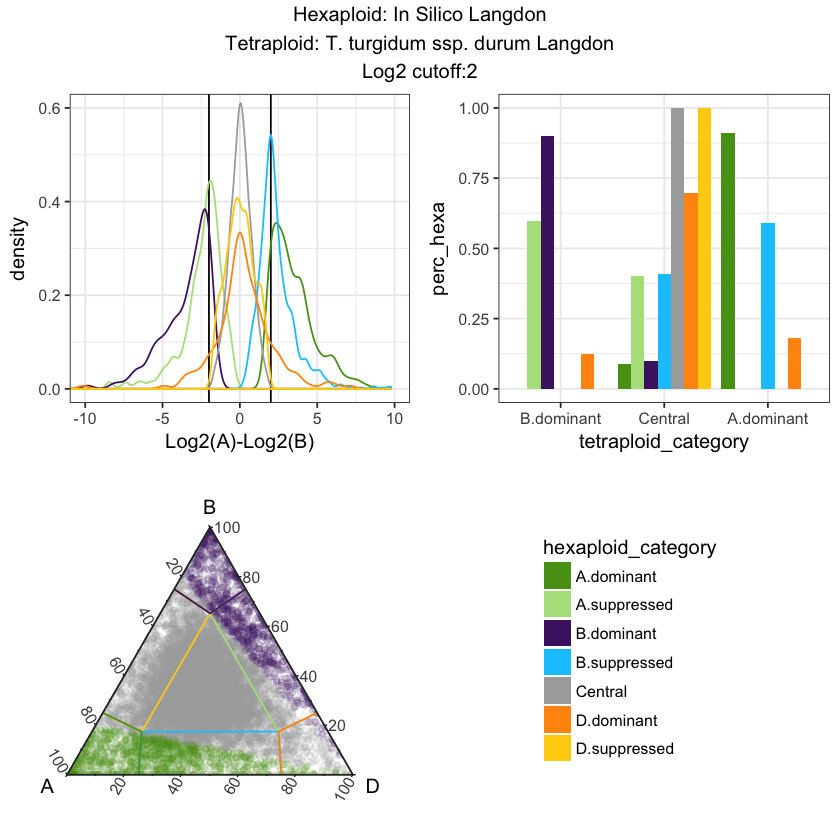

In [45]:
g<-plot_tetraploid_from_movment(triads_silico_langdon, filter_hom_values, 
                                 factor="In Silico Langdon", 
                                factor_tetraploid="T. turgidum ssp. durum Langdon", 
                                log2_cutoff=2)
grid.draw(g)

In [46]:
in_silico <- read.csv("./Figures/Synthetic_dominance/In\ Silico_T.\ turgidum\ ssp.\ turgidum\ AS2255_1_hom_values.csv")
synthetic <- read.csv("./Figures/Synthetic_dominance/hexaploid\ S1\ plants\ of\ AS2255\ x\ AS60_T.\ turgidum\ ssp.\ turgidum\ AS2255_1_hom_values.csv")
head(in_silico)
head(synthetic)
merged <- sqldf("SELECT 
synthetic.gene, 
synthetic.chr_group,
synthetic.group_id, 
synthetic.hexaploid_category as synthetic_hexaploid_category,
synthetic.hexaploid_value as synthetic_hexaploid_value,
synthetic.normalised_triad as synthetic_hexaploid_normalised_triad,
in_silico.hexaploid_category as in_silico_hexaploid_category,
in_silico.hexaploid_value as in_silico_hexaploid_value,
in_silico.normalised_triad as in_silico_hexaploid_normalised_triad
FROM 
synthetic JOIN in_silico 
ON
synthetic.gene      = in_silico.gene AND 
synthetic.chr_group = in_silico.chr_group AND
synthetic.group_id  = in_silico.group_id  

")
nrow(merged)
nrow(in_silico)
nrow(synthetic)
merged$diff_norm_triad_sil <- merged$in_silico_hexaploid_normalised_triad  - merged$synthetic_hexaploid_normalised_triad
merged$diff_norm_triad_syn <- merged$synthetic_hexaploid_normalised_triad - merged$in_silico_hexaploid_normalised_triad  
merged$sil_cat<-paste0(substr(merged$in_silico_hexaploid_category, 1, 5), " Silico")
merged$syn_cat<-paste0(substr(merged$synthetic_hexaploid_category, 1, 5), " Syn")
require(plyr)
n_merged <- ddply(.data=merged, 
                 .(sil_cat, syn_cat), 
                 summarize, 
                 n=paste("n =", length(gene)/3))
head(n_merged)

X group_id factor                           A        B        log2_ratio
1 1 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
2 2 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
3 3 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
4 4 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
5 5 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
6 6 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
  hexaploid_category hexaploid_value normalised_triad gene              
1 Central            0.8511800       0.2239043        TraesCS5A01G531900
2 Central            1.1504167       0.3026190        TraesCS4B01G363600
3 Central            1.7999383       0.4734767        TraesCS4D01G357000
4 Central            0.7118060       0.4161019        TraesCS3A01G462400
5 Central            0.3593787       0.2100827        TraesCS3B01G505400
6 Central            0.6394683       0.3738153        TraesCS3D01G456100
  chr_group hexaploid_factor tetraploid_category log2_cutoff hexaploid
1 A         In Silico        Central             1           In Silico
2 B         In Silico        Central             1           In Silico
3 D         In Silico        Central             1           In Silico
4 A         In Silico        Central             1           In Silico
5 B         In Silico        Central             1           In Silico
6 D         In Silico        Central             1           In Silico
  tetraploid                      
1 T. turgidum ssp. turgidum AS2255
2 T. turgidum ssp. turgidum AS2255
3 T. turgidum ssp. turgidum AS2255
4 T. turgidum ssp. turgidum AS2255
5 T. turgidum ssp. turgidum AS2255
6 T. turgidum ssp. turgidum AS2255

X group_id factor                           A        B        log2_ratio
1 1 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
2 2 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
3 3 412      T. turgidum ssp. turgidum AS2255 1.276770 1.725625 -0.4346203
4 4 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
5 5 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
6 6 451      T. turgidum ssp. turgidum AS2255 1.067709 0.539068  0.9859793
  hexaploid_category hexaploid_value normalised_triad gene              
1 D.suppressed       0.8257365       0.6249191        TraesCS5A01G531900
2 D.suppressed       0.3235750       0.2448822        TraesCS4B01G363600
3 D.suppressed       0.1720380       0.1301987        TraesCS4D01G357000
4 Central            0.6693795       0.5535564        TraesCS3A01G462400
5 Central            0.2971785       0.2457575        TraesCS3B01G505400
6 Central            0.2426765       0.2006861        TraesCS3D01G456100
  chr_group hexaploid_factor                     tetraploid_category
1 A         hexaploid S1 plants of AS2255 x AS60 Central            
2 B         hexaploid S1 plants of AS2255 x AS60 Central            
3 D         hexaploid S1 plants of AS2255 x AS60 Central            
4 A         hexaploid S1 plants of AS2255 x AS60 Central            
5 B         hexaploid S1 plants of AS2255 x AS60 Central            
6 D         hexaploid S1 plants of AS2255 x AS60 Central            
  log2_cutoff hexaploid                           
1 1           hexaploid S1 plants of AS2255 x AS60
2 1           hexaploid S1 plants of AS2255 x AS60
3 1           hexaploid S1 plants of AS2255 x AS60
4 1           hexaploid S1 plants of AS2255 x AS60
5 1           hexaploid S1 plants of AS2255 x AS60
6 1           hexaploid S1 plants of AS2255 x AS60
  tetraploid                      
1 T. turgidum ssp. turgidum AS2255
2 T. turgidum ssp. turgidum AS2255
3 T. turgidum ssp. turgidum AS2255
4 T. turgidum ssp. turgidum AS2255
5 T. turgidum ssp. turgidum AS2255
6 T. turgidum ssp. turgidum AS2255

[1] 31755

[1] 32349

[1] 31965

Loading required package: plyr

Attaching package: ‘plyr’

The following object is masked from ‘package:maps’:

    ozone



sil_cat      syn_cat   n      
1 A.dom Silico A.dom Syn n = 220
2 A.dom Silico B.sup Syn n = 67 
3 A.dom Silico Centr Syn n = 12 
4 A.dom Silico D.dom Syn n = 1  
5 A.dom Silico D.sup Syn n = 34 
6 A.sup Silico A.sup Syn n = 472

In [47]:
merged$diff_log2_tpm_sil <- log2(merged$in_silico_hexaploid_value) - log2(merged$synthetic_hexaploid_value)
merged$diff_log2_tpm_syn <- log2(merged$synthetic_hexaploid_value) - log2(merged$in_silico_hexaploid_value) 
write.csv(merged, row.names=F, file="./Figures/Synthetic_dominance/merged_AS2255xAS60_expectation.csv")



In [48]:
in_silico <- read.csv("./Figures/Synthetic_dominance/In Silico Langdon_T. turgidum ssp. durum Langdon_1_hom_values.csv")
synthetic <- read.csv("./Figures/Synthetic_dominance/hexaploid S1 plants of Langdon x AS60_T. turgidum ssp. durum Langdon_1_hom_values.csv")
merged <- sqldf("SELECT 
synthetic.gene, 
synthetic.chr_group,
synthetic.group_id, 
synthetic.hexaploid_category as synthetic_hexaploid_category,
synthetic.hexaploid_value as synthetic_hexaploid_value,
synthetic.normalised_triad as synthetic_hexaploid_normalised_triad,
in_silico.hexaploid_category as in_silico_hexaploid_category,
in_silico.hexaploid_value as in_silico_hexaploid_value,
in_silico.normalised_triad as in_silico_hexaploid_normalised_triad
FROM 
synthetic JOIN in_silico 
ON
synthetic.gene      = in_silico.gene AND 
synthetic.chr_group = in_silico.chr_group AND
synthetic.group_id  = in_silico.group_id  

")
nrow(merged)
nrow(in_silico)
nrow(synthetic)
merged$diff_norm_triad_sil <- merged$in_silico_hexaploid_normalised_triad  - merged$synthetic_hexaploid_normalised_triad
merged$diff_norm_triad_syn <- merged$synthetic_hexaploid_normalised_triad - merged$in_silico_hexaploid_normalised_triad  


merged$diff_log2_tpm_sil <- log2(merged$in_silico_hexaploid_value) - log2(merged$synthetic_hexaploid_value)
merged$diff_log2_tpm_syn <- log2(merged$synthetic_hexaploid_value) - log2(merged$in_silico_hexaploid_value) 




merged$sil_cat<-paste0(substr(merged$in_silico_hexaploid_category, 1, 5), " Silico")
merged$syn_cat<-paste0(substr(merged$synthetic_hexaploid_category, 1, 5), " Syn")
n_merged <- ddply(.data=merged, 
                 .(sil_cat, syn_cat), 
                 summarize, 
                 n=paste("n =", length(gene)/3))
head(n_merged)
write.csv(merged, row.names=F, file="./Figures/Synthetic_dominance/merged_LangdonxAS60_expectation.csv")

[1] 32748

[1] 33498

[1] 32994

sil_cat      syn_cat   n      
1 A.dom Silico A.dom Syn n = 226
2 A.dom Silico B.dom Syn n = 1  
3 A.dom Silico B.sup Syn n = 91 
4 A.dom Silico Centr Syn n = 28 
5 A.dom Silico D.dom Syn n = 3  
6 A.dom Silico D.sup Syn n = 40

In [49]:
langdon<-read.csv("./Figures/Synthetic_dominance/merged_LangdonxAS60_expectation.csv")
langdon$cross <- "Langdon x AS60"
AS2255 <-read.csv("./Figures/Synthetic_dominance/merged_AS2255xAS60_expectation.csv")
AS2255$cross <- "AS2255 x AS60"
langdon$sil_cat <- NULL
langdon$syn_cat <- NULL
AS2255$sil_cat <- NULL
AS2255$syn_cat <- NULL
cs_leaf <-read.csv("./synthetic/MinTPM1_LeafCategories_hc_cs_no_stress.csv")
cs_leaf$variety <- "Chinese Spring"
az_leaf <-read.csv("./synthetic/LeafCategories_hc_Development_no_stress.csv")
az_leaf$variety <- "Azhurnaya"
head(az_leaf)

group_id description  general_description value       factor
1 402      Central      Central              9.74488667 all   
2 402      Central      Central              6.02151677 all   
3 402      Central      Central              7.19595900 all   
4 413      A.suppressed Suppressed           0.03398872 all   
5 413      A.suppressed Suppressed          16.18534900 all   
6 413      A.suppressed Suppressed          14.25498500 all   
  gene               samples chr_group triad_sum normalised_triad
1 TraesCS4A01G184700 6       A         22.96236  0.424385195     
2 TraesCS4B01G134000 6       B         22.96236  0.262234201     
3 TraesCS4D01G128900 6       D         22.96236  0.313380604     
4 TraesCS5A01G461200 6       A         30.47432  0.001115323     
5 TraesCS5B01G471300 6       B         30.47432  0.531114314     
6 TraesCS5D01G473800 6       D         30.47432  0.467770363     
  dataset               variety  
1 Developmant_FifthLeaf Azhurnaya
2 Developmant_FifthLeaf Azhurnaya
3 Developmant_FifthLeaf Azhurnaya
4 Developmant_FifthLeaf Azhurnaya
5 Developmant_FifthLeaf Azhurnaya
6 Developmant_FifthLeaf Azhurnaya

In [50]:
merge_synt_with_variety<-function(syn, var){
    merged<-sqldf("
SELECT
syn.*,
var.description as variety_category, 
var.value as variety_value, 
var.normalised_triad as variety_triad, 
var.variety
FROM
syn
JOIN var ON syn.gene = var.gene")
    return (merged)
}
lan_az<-merge_synt_with_variety(langdon, az_leaf)
head(lan_az)
nrow(lan_az)
lan_cs<-merge_synt_with_variety(langdon, cs_leaf)
as_az<-merge_synt_with_variety(AS2255, az_leaf)
as_cs<-merge_synt_with_variety(AS2255, cs_leaf)
write.csv(lan_az, "./Figures/Synthetic_dominance/pro_syn_var/Langdon_Azhurnaya.csv", row.names =F)
write.csv(lan_cs, "./Figures/Synthetic_dominance/pro_syn_var/Langdon_CS.csv", row.names =F)
write.csv(as_cs, "./Figures/Synthetic_dominance/pro_syn_var/AS2255_CS.csv", row.names =F)
write.csv(as_az, "./Figures/Synthetic_dominance/pro_syn_var/AS2255_Azhurnaya.csv", row.names =F)
lan_az_select<-lan_az[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]
lan_cs_select<-lan_cs[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]
as_cs_select<-as_cs[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]
as_az_select<-as_az[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]




head(lan_az_select)

print(levels(lan_az_select$in_silico_hexaploid_category))
levels(lan_az_select$in_silico_hexaploid_category) <- list( Central      = '1.Central'      , 
                                                            A.dominant   = '2.A.dominant'   , 
                                                            A.suppressed = '3.A.suppressed' ,
                                                            B.dominant   = '4.B.dominant'   ,
                                                            B.suppressed = '5.B.suppressed' ,
                                                            D.dominant   = '6.D.dominant'   ,
                                                            D.suppressed = '7.D.suppressed'  )
head(lan_az_select)
print(levels(lan_az_select$in_silico_hexaploid_category))
write.csv(lan_az_select, "./Figures/Synthetic_dominance/pro_syn_var/short_Langdon_Azhurnaya.csv", row.names =F)
write.csv(lan_cs_select, "./Figures/Synthetic_dominance/pro_syn_var/short_Langdon_CS.csv", row.names =F)
write.csv(as_cs_select, "./Figures/Synthetic_dominance/pro_syn_var/short_AS2255_CS.csv", row.names =F)
write.csv(as_az_select, "./Figures/Synthetic_dominance/pro_syn_var/short_AS2255_Azhurnaya.csv", row.names =F)
levels(lan_az_select$variety_category)[levels(lan_az_select$variety_category)=="Central"] <- "1.Central"
head(lan_az_select)
lan_az_select<-lan_az[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]


lan_az_select$variety_category<- factor(lan_az_select$variety_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_az_select$in_silico_hexaploid_category<- factor(lan_az_select$in_silico_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_az_select$synthetic_hexaploid_category<- factor(lan_az_select$synthetic_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
       
head(lan_az_select)

lan_cs_select<-lan_cs[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]


lan_cs_select$variety_category<- factor(lan_cs_select$variety_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_cs_select$in_silico_hexaploid_category<- factor(lan_cs_select$in_silico_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_cs_select$synthetic_hexaploid_category<- factor(lan_cs_select$synthetic_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
       
head(lan_cs_select)
as_cs_select<-as_cs[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]


as_cs_select$variety_category<- factor(as_cs_select$variety_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
as_cs_select$in_silico_hexaploid_category<- factor(as_cs_select$in_silico_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
as_cs_select$synthetic_hexaploid_category<- factor(as_cs_select$synthetic_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
       
head(as_cs_select)

lan_cs_select<-lan_cs[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]


lan_cs_select$variety_category<- factor(lan_cs_select$variety_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_cs_select$in_silico_hexaploid_category<- factor(lan_cs_select$in_silico_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
lan_cs_select$synthetic_hexaploid_category<- factor(lan_cs_select$synthetic_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
       
head(lan_cs_select)
as_az_select<-as_az[,c('gene', 'chr_group', 'group_id', 'in_silico_hexaploid_category','synthetic_hexaploid_category',  'variety_category', 'cross', 'variety')]


as_az_select$variety_category<- factor(as_az_select$variety_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
as_az_select$in_silico_hexaploid_category<- factor(as_az_select$in_silico_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
as_az_select$synthetic_hexaploid_category<- factor(as_az_select$synthetic_hexaploid_category,
                                        levels = c('Central'     , 
                                                   'A.dominant'  , 
                                                   'A.suppressed', 
                                                   'B.dominant'  , 
                                                   'B.suppressed', 
                                                   'D.dominant'  , 
                                                   'D.suppressed' )
                                        , labels = c('1.Central'      ,
                                                     '2.A.dominant'   ,
                                                     '3.A.suppressed' ,
                                                     '4.B.dominant'   ,
                                                     '5.B.suppressed' ,
                                                     '6.D.dominant'   ,
                                                     '7.D.suppressed'  ))
       
head(as_az_select)
write.csv(lan_az_select, "./Figures/Synthetic_dominance/pro_syn_var/short_Langdon_Azhurnaya.csv", row.names =F)
write.csv(lan_cs_select, "./Figures/Synthetic_dominance/pro_syn_var/short_Langdon_CS.csv", row.names =F)
write.csv(as_cs_select, "./Figures/Synthetic_dominance/pro_syn_var/short_AS2255_CS.csv", row.names =F)
write.csv(as_az_select, "./Figures/Synthetic_dominance/pro_syn_var/short_AS2255_Azhurnaya.csv", row.names =F)
head(lan_az_select)

gene               chr_group group_id synthetic_hexaploid_category
1 TraesCS3A01G462400 A         451      B.suppressed                
2 TraesCS3B01G505400 B         451      B.suppressed                
3 TraesCS3D01G456100 D         451      B.suppressed                
4 TraesCS3A01G440700 A         474      Central                     
5 TraesCS3B01G474800 B         474      Central                     
6 TraesCS3D01G433300 D         474      Central                     
  synthetic_hexaploid_value synthetic_hexaploid_normalised_triad
1 1.1263350                 0.62360219                          
2 0.0615405                 0.03407227                          
3 0.6183000                 0.34232554                          
4 0.2915515                 0.22933656                          
5 0.6500695                 0.51134947                          
6 0.3296613                 0.25931397                          
  in_silico_hexaploid_category in_silico_hexaploid_value
1 B.suppressed                 1.22059333               
2 B.suppressed                 0.15993067               
3 B.suppressed                 0.63946833               
4 B.suppressed                 1.19285333               
5 B.suppressed                 0.03873853               
6 B.suppressed                 0.77839333               
  in_silico_hexaploid_normalised_triad diff_norm_triad_sil diff_norm_triad_syn
1 0.60425642                           -0.01934577          0.01934577        
2 0.07917390                            0.04510163         -0.04510163        
3 0.31656968                           -0.02575585          0.02575585        
4 0.59346374                            0.36412718         -0.36412718        
5 0.01927304                           -0.49207642          0.49207642        
6 0.38726322                            0.12794924         -0.12794924        
  diff_log2_tpm_sil diff_log2_tpm_syn cross          variety_category
1  0.11594663       -0.11594663       Langdon x AS60 Central         
2  1.37783853       -1.37783853       Langdon x AS60 Central         
3  0.04856591       -0.04856591       Langdon x AS60 Central         
4  2.03259402       -2.03259402       Langdon x AS60 Central         
5 -4.06875273        4.06875273       Langdon x AS60 Central         
6  1.23951504       -1.23951504       Langdon x AS60 Central         
  variety_value variety_triad variety  
1 2.996650      0.4051677     Azhurnaya
2 2.252626      0.3045705     Azhurnaya
3 2.146797      0.2902618     Azhurnaya
4 2.484140      0.2613545     Azhurnaya
5 2.088564      0.2197362     Azhurnaya
6 4.932164      0.5189093     Azhurnaya

[1] 30798

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      B.suppressed                
2 TraesCS3B01G505400 B         451      B.suppressed                
3 TraesCS3D01G456100 D         451      B.suppressed                
4 TraesCS3A01G440700 A         474      B.suppressed                
5 TraesCS3B01G474800 B         474      B.suppressed                
6 TraesCS3D01G433300 D         474      B.suppressed                
  synthetic_hexaploid_category variety_category cross          variety  
1 B.suppressed                 Central          Langdon x AS60 Azhurnaya
2 B.suppressed                 Central          Langdon x AS60 Azhurnaya
3 B.suppressed                 Central          Langdon x AS60 Azhurnaya
4 Central                      Central          Langdon x AS60 Azhurnaya
5 Central                      Central          Langdon x AS60 Azhurnaya
6 Central                      Central          Langdon x AS60 Azhurnaya

[1] "A.dominant"   "A.suppressed" "B.dominant"   "B.suppressed" "Central"     
[6] "D.dominant"   "D.suppressed"


gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      B.suppressed                
2 TraesCS3B01G505400 B         451      B.suppressed                
3 TraesCS3D01G456100 D         451      B.suppressed                
4 TraesCS3A01G440700 A         474      B.suppressed                
5 TraesCS3B01G474800 B         474      B.suppressed                
6 TraesCS3D01G433300 D         474      B.suppressed                
  synthetic_hexaploid_category variety_category cross          variety  
1 B.suppressed                 Central          Langdon x AS60 Azhurnaya
2 B.suppressed                 Central          Langdon x AS60 Azhurnaya
3 B.suppressed                 Central          Langdon x AS60 Azhurnaya
4 Central                      Central          Langdon x AS60 Azhurnaya
5 Central                      Central          Langdon x AS60 Azhurnaya
6 Central                      Central          Langdon x AS60 Azhurnaya

[1] "Central"      "A.dominant"   "A.suppressed" "B.dominant"   "B.suppressed"
[6] "D.dominant"   "D.suppressed"


gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      B.suppressed                
2 TraesCS3B01G505400 B         451      B.suppressed                
3 TraesCS3D01G456100 D         451      B.suppressed                
4 TraesCS3A01G440700 A         474      B.suppressed                
5 TraesCS3B01G474800 B         474      B.suppressed                
6 TraesCS3D01G433300 D         474      B.suppressed                
  synthetic_hexaploid_category variety_category cross          variety  
1 B.suppressed                 Central          Langdon x AS60 Azhurnaya
2 B.suppressed                 Central          Langdon x AS60 Azhurnaya
3 B.suppressed                 Central          Langdon x AS60 Azhurnaya
4 Central                      Central          Langdon x AS60 Azhurnaya
5 Central                      Central          Langdon x AS60 Azhurnaya
6 Central                      Central          Langdon x AS60 Azhurnaya

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      5.B.suppressed              
2 TraesCS3B01G505400 B         451      5.B.suppressed              
3 TraesCS3D01G456100 D         451      5.B.suppressed              
4 TraesCS3A01G440700 A         474      5.B.suppressed              
5 TraesCS3B01G474800 B         474      5.B.suppressed              
6 TraesCS3D01G433300 D         474      5.B.suppressed              
  synthetic_hexaploid_category variety_category cross          variety  
1 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
2 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
3 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
4 1.Central                    1.Central        Langdon x AS60 Azhurnaya
5 1.Central                    1.Central        Langdon x AS60 Azhurnaya
6 1.Central                    1.Central        Langdon x AS60 Azhurnaya

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS5A01G531900 A         412      3.A.suppressed              
2 TraesCS4B01G363600 B         412      3.A.suppressed              
3 TraesCS4D01G357000 D         412      3.A.suppressed              
4 TraesCS3A01G462400 A         451      5.B.suppressed              
5 TraesCS3B01G505400 B         451      5.B.suppressed              
6 TraesCS3D01G456100 D         451      5.B.suppressed              
  synthetic_hexaploid_category variety_category cross          variety       
1 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
2 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
3 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
4 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring
5 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring
6 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS5A01G531900 A         412      1.Central                   
2 TraesCS4B01G363600 B         412      1.Central                   
3 TraesCS4D01G357000 D         412      1.Central                   
4 TraesCS3A01G462400 A         451      1.Central                   
5 TraesCS3B01G505400 B         451      1.Central                   
6 TraesCS3D01G456100 D         451      1.Central                   
  synthetic_hexaploid_category variety_category cross         variety       
1 7.D.suppressed               2.A.dominant     AS2255 x AS60 Chinese Spring
2 7.D.suppressed               2.A.dominant     AS2255 x AS60 Chinese Spring
3 7.D.suppressed               2.A.dominant     AS2255 x AS60 Chinese Spring
4 1.Central                    5.B.suppressed   AS2255 x AS60 Chinese Spring
5 1.Central                    5.B.suppressed   AS2255 x AS60 Chinese Spring
6 1.Central                    5.B.suppressed   AS2255 x AS60 Chinese Spring

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS5A01G531900 A         412      3.A.suppressed              
2 TraesCS4B01G363600 B         412      3.A.suppressed              
3 TraesCS4D01G357000 D         412      3.A.suppressed              
4 TraesCS3A01G462400 A         451      5.B.suppressed              
5 TraesCS3B01G505400 B         451      5.B.suppressed              
6 TraesCS3D01G456100 D         451      5.B.suppressed              
  synthetic_hexaploid_category variety_category cross          variety       
1 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
2 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
3 5.B.suppressed               2.A.dominant     Langdon x AS60 Chinese Spring
4 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring
5 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring
6 5.B.suppressed               5.B.suppressed   Langdon x AS60 Chinese Spring

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      1.Central                   
2 TraesCS3B01G505400 B         451      1.Central                   
3 TraesCS3D01G456100 D         451      1.Central                   
4 TraesCS1A01G020300 A         482      4.B.dominant                
5 TraesCS1B01G024300 B         482      4.B.dominant                
6 TraesCS1D01G019800 D         482      4.B.dominant                
  synthetic_hexaploid_category variety_category cross         variety  
1 1.Central                    1.Central        AS2255 x AS60 Azhurnaya
2 1.Central                    1.Central        AS2255 x AS60 Azhurnaya
3 1.Central                    1.Central        AS2255 x AS60 Azhurnaya
4 4.B.dominant                 4.B.dominant     AS2255 x AS60 Azhurnaya
5 4.B.dominant                 4.B.dominant     AS2255 x AS60 Azhurnaya
6 4.B.dominant                 4.B.dominant     AS2255 x AS60 Azhurnaya

gene               chr_group group_id in_silico_hexaploid_category
1 TraesCS3A01G462400 A         451      5.B.suppressed              
2 TraesCS3B01G505400 B         451      5.B.suppressed              
3 TraesCS3D01G456100 D         451      5.B.suppressed              
4 TraesCS3A01G440700 A         474      5.B.suppressed              
5 TraesCS3B01G474800 B         474      5.B.suppressed              
6 TraesCS3D01G433300 D         474      5.B.suppressed              
  synthetic_hexaploid_category variety_category cross          variety  
1 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
2 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
3 5.B.suppressed               1.Central        Langdon x AS60 Azhurnaya
4 1.Central                    1.Central        Langdon x AS60 Azhurnaya
5 1.Central                    1.Central        Langdon x AS60 Azhurnaya
6 1.Central                    1.Central        Langdon x AS60 Azhurnaya